## 1. Imports

In [102]:
###database
import psycopg2
###basic
import pandas                as pd
import numpy                 as np
import random

###chart plot
import matplotlib.pyplot     as     plt
import matplotlib.gridspec   as     gridspec
import seaborn               as     sns
import scikitplot as skplt

###Metrics and models imports
#models and feature selection
from   sklearn.model_selection import StratifiedShuffleSplit, train_test_split, RandomizedSearchCV
from   sklearn.linear_model    import LogisticRegression
from   sklearn.ensemble        import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier
from   sklearn.neighbors       import KNeighborsClassifier
from   sklearn.naive_bayes     import GaussianNB
import xgboost as xgb 
#metrics
from   sklearn.metrics         import roc_auc_score,  precision_score, recall_score, classification_report, accuracy_score
from   boruta                  import BorutaPy
#save model
import pickle

###encodings
from   sklearn.preprocessing   import OneHotEncoder, RobustScaler, MinMaxScaler, StandardScaler

###display
from   IPython.display         import Image
from   IPython.display         import display

import warnings

## 2. Help functions / Settings

### 2.1 Settings

In [2]:
#Credentials
pgHOST = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
pgPORT = '5432'
database = 'comunidadedsdb'
user ='member'
password = 'cdspa'

In [3]:
#warings ignore
warnings.filterwarnings('ignore')

In [2]:
#Seaborn Settings
sns.set( rc={'figure.figsize': (40,10 )} )

### 2.2 Functions

#### General functions

In [2]:
#get data in DB
def get_data(query):
    myConnection = psycopg2.connect( host = pgHOST, user=user, password=password, dbname=database )
    df = pd.read_sql( query, myConnection)
    myConnection.close()
    return df
#data cleaning
def dt_cleaning(df):
    #cleaning up duplicate columns
    df['ident'] = df.iloc[0:,0]
    df.drop(columns='id', inplace=True)
    df.rename(columns={'ident':'id'}, inplace=True)
    #reordering columns
    df = df[[
        'id','gender', 'age', 'region_code', 'policy_sales_channel',
        'previously_insured', 'annual_premium', 'vintage', 'driving_license', 
        'vehicle_age', 'vehicle_damage', 'response'
    ]].copy()
    df['vehicle_damage'] = df['vehicle_damage'].apply( lambda x: 0 if x == 'No' else 1 )
    return df


#split train test stratified
def stratified_split (df , feature):    
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=11)

    for train_index, test_index in split.split( df, df[feature] ):
        train_set = df.loc[train_index].reset_index(drop=True)
        test_set = df.loc[test_index].reset_index(drop=True)
    return train_set, test_set    

#One Hot Encoding
def data_hotencoding(df, column):
    ohe       = OneHotEncoder()
    g         = ohe.fit_transform( df[column].values.reshape(-1,1) ).toarray()
    df_ohe    = pd.DataFrame( g, columns=[ str( column ) + '_' + str( int( i ) ) for i in range( g.shape[1] ) ] )
    df = pd.concat( [df, df_ohe], axis= 1 )
    df = df.drop(columns=[column])
    
    return df    

def data_rescaling(df):
    df_aux = df.copy()
    rs = RobustScaler()
    mms = MinMaxScaler()

    ###MinMaxScaler
    #rescaling age
    df_aux['age']                  = mms.fit_transform( df[['age']].values )
    #rescaling vintage
    df_aux['vintage']              = mms.fit_transform( df[['vintage']].values ) 
    #rescaling policy_sales_channel
    df_aux['policy_sales_channel'] = mms.fit_transform( df[['policy_sales_channel']].values )
    #rescaling region_code
    df_aux['region_code'] = mms.fit_transform( df[['region_code']].values )

    ###RobustScaler
    #annual_premium
    df_aux['annual_premium']       = rs.fit_transform( df[['annual_premium']].values )
    return df_aux    

In [3]:
def data_preprocessing ( data ):
    ### Standardization
    ss                                   = StandardScaler()
    #annual_premium
    data['annual_premium']               = ss.fit_transform( data[['annual_premium']].values )

    ###Rescaling
    mms_age                              = MinMaxScaler()
    mms_vintage                          = MinMaxScaler()
    #age   
    data['age']                          = mms_age.fit_transform( data[['age']].values )
    #vintage   
    data['vintage']                      = mms_vintage.fit_transform( data[['vintage']].values )

    ### Encoding
    ## Target Encoding
    #region_code          --- One Hot Encoding ( As there are many coders, it doesn't apply ) | Frequency Encoder | Target Encoding ( In Use ) | Wighted Target Encoding 
    target_enc_region_code              = data.groupby( 'region_code' )['response'].mean()
    data.loc[:, 'region_code']          = data['region_code'].map( target_enc_region_code )
    #gender               --- One Hot Encoding ( In Use ) | Order Encoding | Frequency Encoder
    target_gender                       = data.groupby( 'gender' )['response'].mean()
    data.loc[:, 'gender']               = data['gender'].map( target_gender )
    ## One Hot Encoding
    #vehicle_age          --- One Hot Encoding ( In Use ) | Order Encoding | Frequency Encoder
    data = pd.get_dummies( data, prefix = 'vehicle_age', columns = ['vehicle_age'] )
    ## Frequency Encoding
    #policy_sales_channel --- Target Encoding | Frequency Encoder ( In use )
    freq_policy_sales_chanel            = data.groupby( 'policy_sales_channel' ).size() / len(data)
    data.loc[:, 'policy_sales_channel'] = data['policy_sales_channel'].map( freq_policy_sales_chanel )
    return data

#### Cross Validation

In [4]:
def cross_validation( model_name, model, x_train,y_train, kfolds ):
    '''Name of Model | The Model | Train Data(Without target) | Target Data train | Number of Kfolds'''
    if kfolds <= 1:
        kfolds = 2
    #How CV will be based on regression, this will be reseted
    x_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)

    index_max = x_train.index.max()
    range_ = int(index_max / kfolds)

    #create the recived score metrics variabels
    roc_  = []
    precision = []
    recall = []
    
    for k in reversed( range( range_, index_max, range_ ) ):
        #defining ranges
        validation_start_date = k - range_
        validation_end_date = k
        
        ###filtering dataset
        #validation
        x_validation = x_train[( x_train.index > validation_start_date ) & ( x_train.index < validation_end_date ) ]
        y_validation = y_train[( y_train.index > validation_start_date ) & ( y_train.index < validation_end_date ) ]
        #train
        x_training = x_train[( x_train.index <= validation_start_date ) | ( x_train.index >= validation_end_date )]
        y_training = y_train[( y_train.index <= validation_start_date ) | ( y_train.index >= validation_end_date )]

        ###training and predict
        #train
        m = model.fit( x_training, y_training )

        ### Predict_proba
        y_hat = m.predict_proba( x_validation )[:, 1]    
        #performance calculation
        roc_.append( roc_auc_score( y_validation, y_hat ) )

        ### Predict
        y_hat = m.predict( x_validation )
        #performance calculation
        precision.append( precision_score( y_validation, y_hat ) )
        recall.append( recall_score( y_validation, y_hat ) )
        
        
    result = pd.DataFrame(
        {'Model Name' : model_name,
        'ROC AUC Score CV'      : np.round(np.mean( roc_ )      * 100 ).astype( str ) + '%  |  +/-  |  ' + np.round( np.std( roc_ ) ).astype( str ),
        'Precision'             : np.round(np.mean( precision ) * 100 ).astype( str ) + '%  |  +/-  |  ' + np.round( np.std( precision ) ).astype( str ),
        'Recall'                : np.round(np.mean( recall )    * 100 ).astype( str ) + '%  |  +/-  |  ' + np.round( np.std( recall ) ).astype( str ),
        },index=[0]
    )
        

    return result    

#### Precision/recall @k

In [5]:
def precision_at_k( df, k = 2000 ):
    ''''| Imput : Dataframe || "K" number | 
        | Return: @K precision (float) |
    '''
    df['ranking']      = list( np.arange( 1, len( df ) +1, 1 ) )
    df = df[['ranking', 'target', 'propensity_score']].copy()
    df['precision_@k'] = df['target'].cumsum() / df['ranking']
    
    return float( df.loc[df.ranking == k, 'precision_@k'] )

In [6]:
def recall_at_k( df, k = 2000 ):
    ''''| Imput : Dataframe || "K" number | 
        | Return: @K precision (float) |
    '''
    #df['ranking']      = list( np.arange( 1, len( df ) +1, 1 ) )
    #df = df[['ranking', 'target', 'propensity_score']].copy()
    df['recall_@k'] = df['target'].cumsum() / df['target'].sum()
    
    return float( df.loc[df.ranking == k, 'recall_@k'] )

## 3. Data collect

In [6]:
query = 'select * \
from pa004.users u \
inner join pa004.insurance i \
on u.id = i.id \
inner join pa004.vehicle v \
on i.id = v.id '

In [7]:
#data = get_data(query)
#data.to_csv('data/data_raw.csv')
data = pd.read_csv('../data/data_raw.csv')

## 4. Data cleaning

In [8]:
df = dt_cleaning(data)

## 5. Initial Data Split

    Para evitar viés ou busca de padrões em sua totalidade, antes da exploração de dados, será feito a divisão dos conjuntos de treino e validação

In [9]:
train_set, test_set = stratified_split(df, 'previously_insured' )

## 6. Data exploration

In [10]:
print('Conjunto de dados contendo: {} linhas e {} colunas'.format(train_set.shape[0], train_set.shape[1]))

Conjunto de dados contendo: 342998 linhas e 12 colunas


In [11]:
train_set.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,response
0,165273,Female,30,28.0,152.0,1,37415.0,279,1,< 1 Year,0,0
1,85333,Male,39,15.0,26.0,0,2630.0,104,1,1-2 Year,1,0
2,57552,Female,25,3.0,152.0,1,30956.0,139,1,< 1 Year,0,0
3,319967,Male,30,26.0,152.0,1,22464.0,56,1,< 1 Year,0,0
4,274712,Male,70,8.0,124.0,1,44507.0,252,1,1-2 Year,0,0


In [12]:
train_set[['policy_sales_channel', 'annual_premium']].describe().T

,count,mean,std,min,25%,50%,75%,max
policy_sales_channel,342998.0,112.031187,54.200866,1.0,29.0,132.0,152.00,163.0
annual_premium,342998.0,30565.854678,17187.737990,2630.0,24408.0,31675.0,39401.75,540165.0


### General analysis

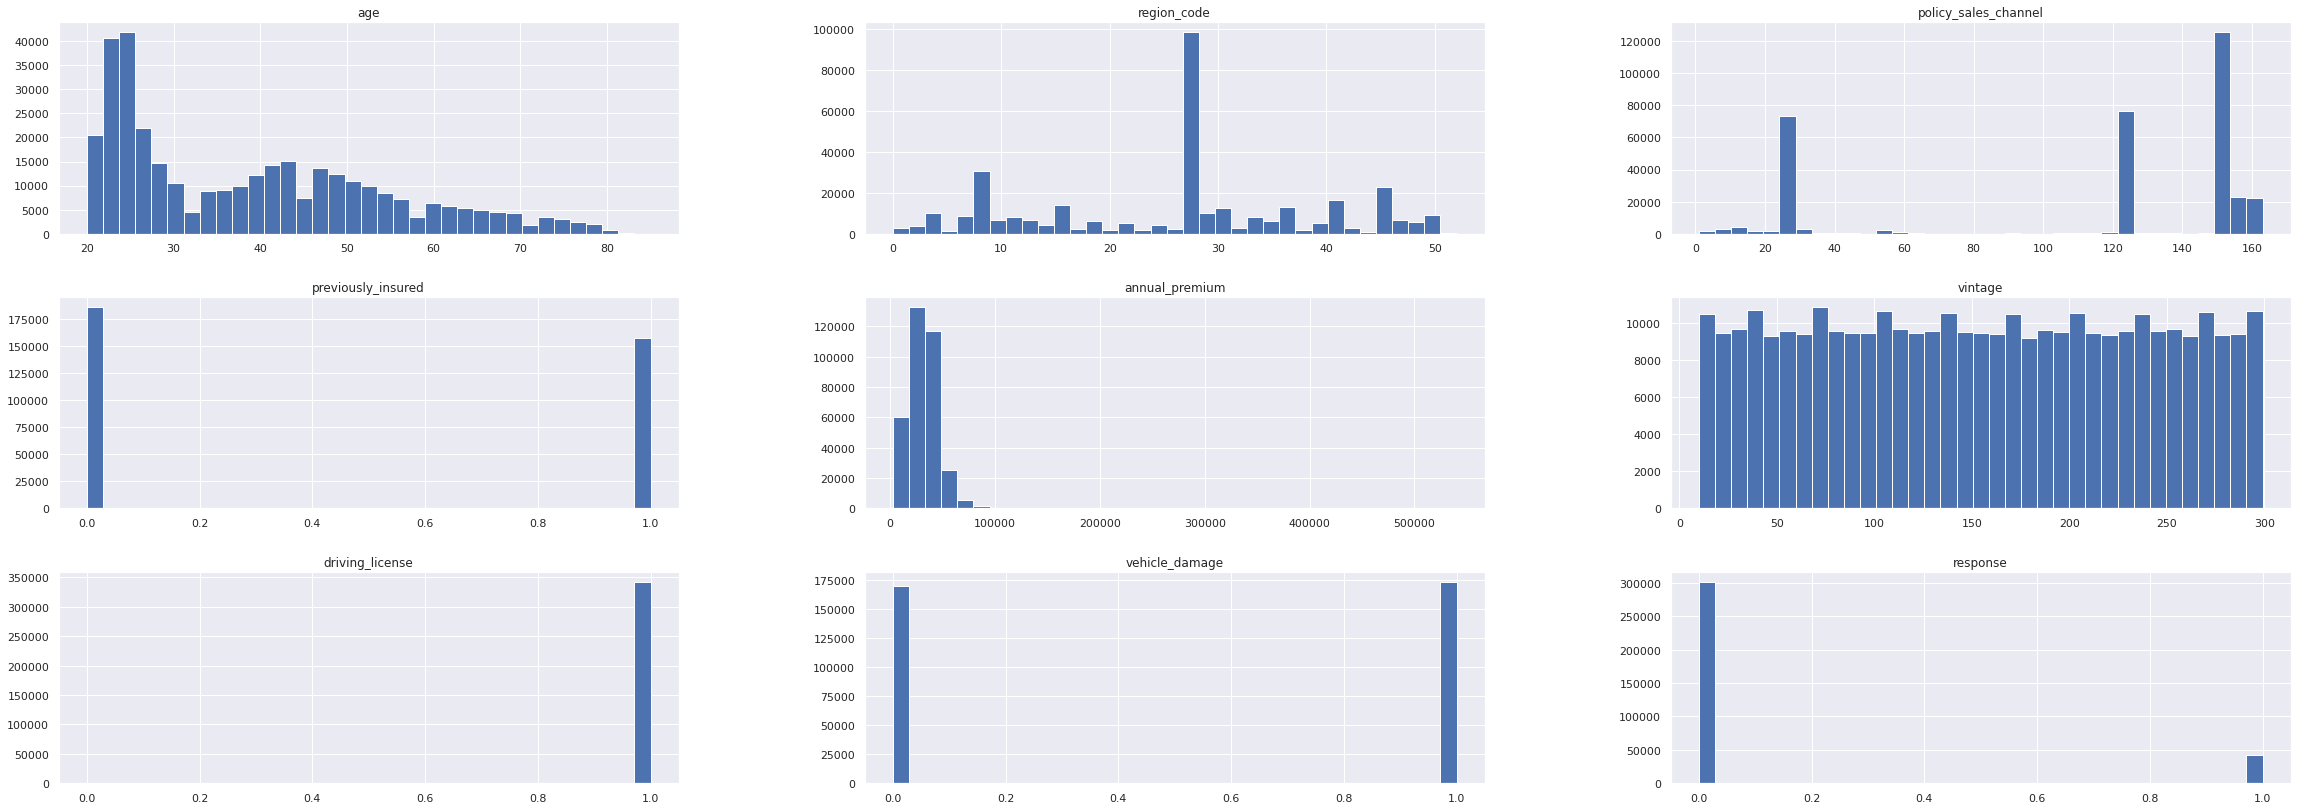

In [13]:
train_set.drop(columns=['id']).hist(figsize=(40,14), bins=35);

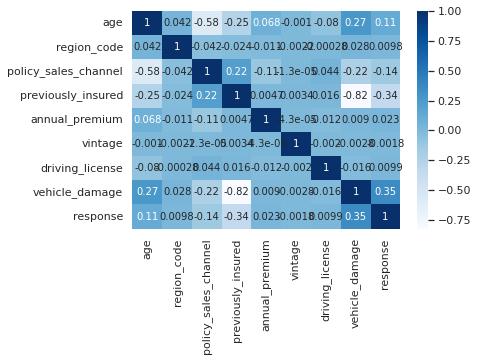

In [14]:
sns.heatmap(
    train_set.drop(columns=['id']).corr(method='pearson'), annot=True,
    cmap = 'Blues'
);

### Age vs Anual Premium

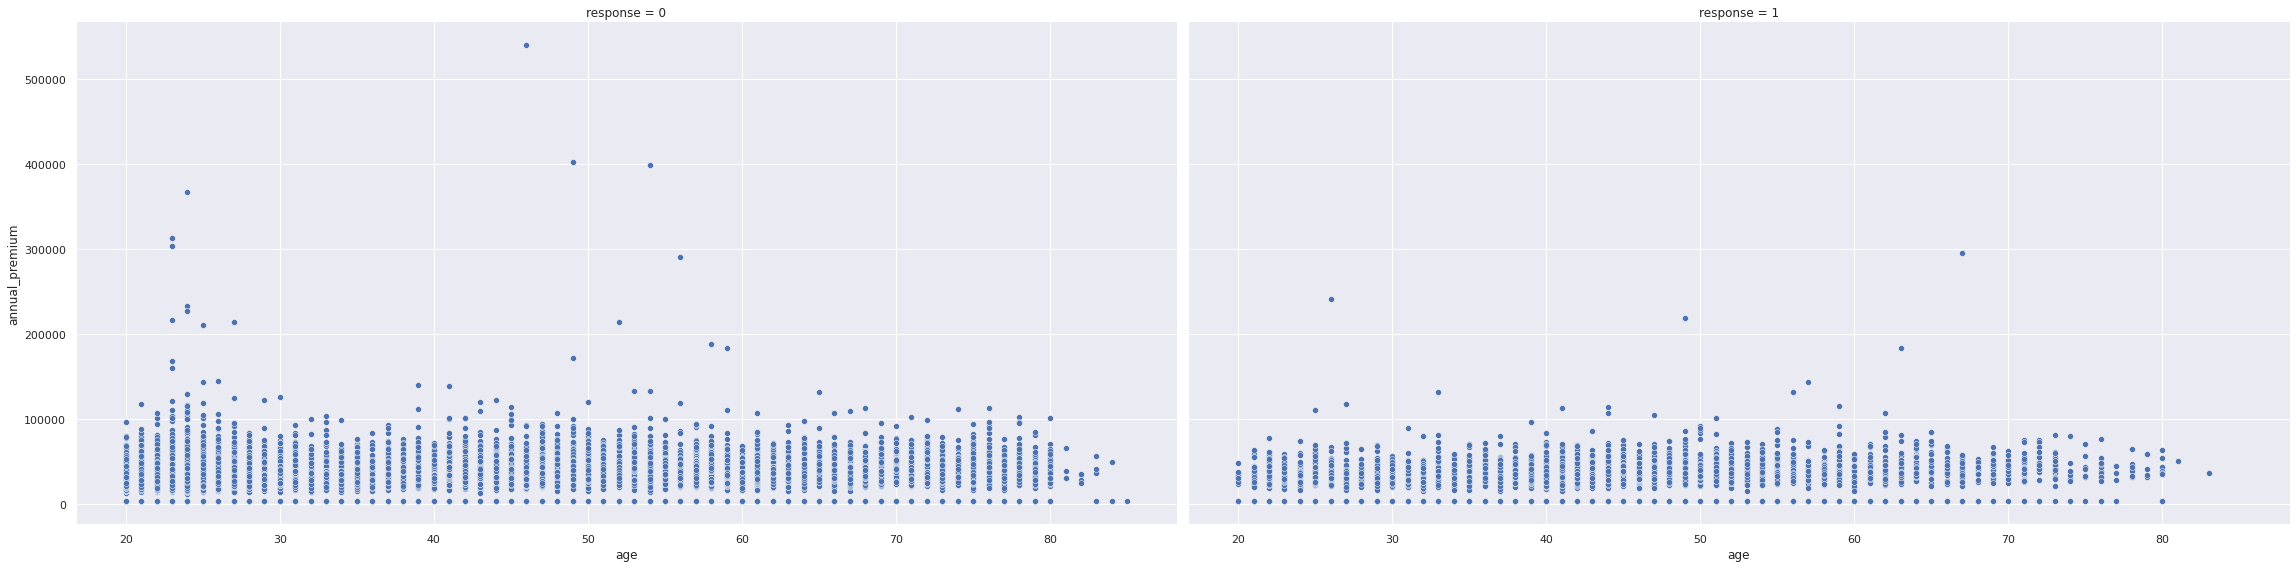

In [15]:
sns.relplot(
    data=test_set, x='age', y='annual_premium', col='response',
    kind='scatter', height=8, aspect = 2
);


### Target Variable

The amount of interestred customers is 13.92% of the total database.


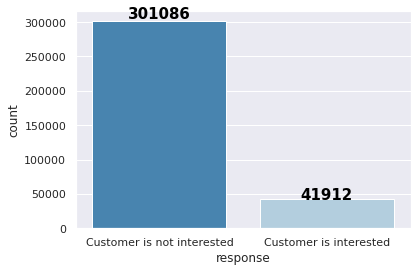

In [16]:
ax = sns.countplot(
    train_set.response, 
    palette='Blues_r'
);
ax.set_xticklabels( [ "Customer is not interested", "Customer is interested" ] );
for i in ax.patches:
    ax.annotate(
        #Texto a ser plotado
        round(i.get_height()),
        #Posição horizontal
        (i.get_x() + i.get_width() /2, i.get_height() + i.get_height() /80 ),
        ha='center' ,   
        color='black',
        weight='bold',
        fontsize=15
    );

print('The amount of interestred customers is {:.2f}% of the total database.'.format( train_set[train_set.response == 1].id.count() *100 / train_set[train_set.response == 0].id.count() ) )

### 6.1 Hypotheses List creation

#### Mind Map

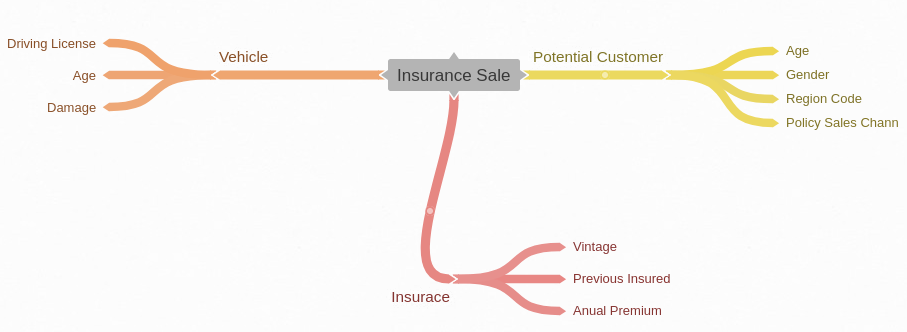

In [17]:
Image('image/MindMap.png', height=500)

#### Hypotheses of correlation list

- Gender             | Response
- Damage             | Response
- Previously Insured | Response
- Vehicle age        | Response

#### Gender x Response

'Nota-se que em ambos os casos de resposta, há mais pessoas do sexo masculino não demonstrando correlação forte entre "gender | response"'

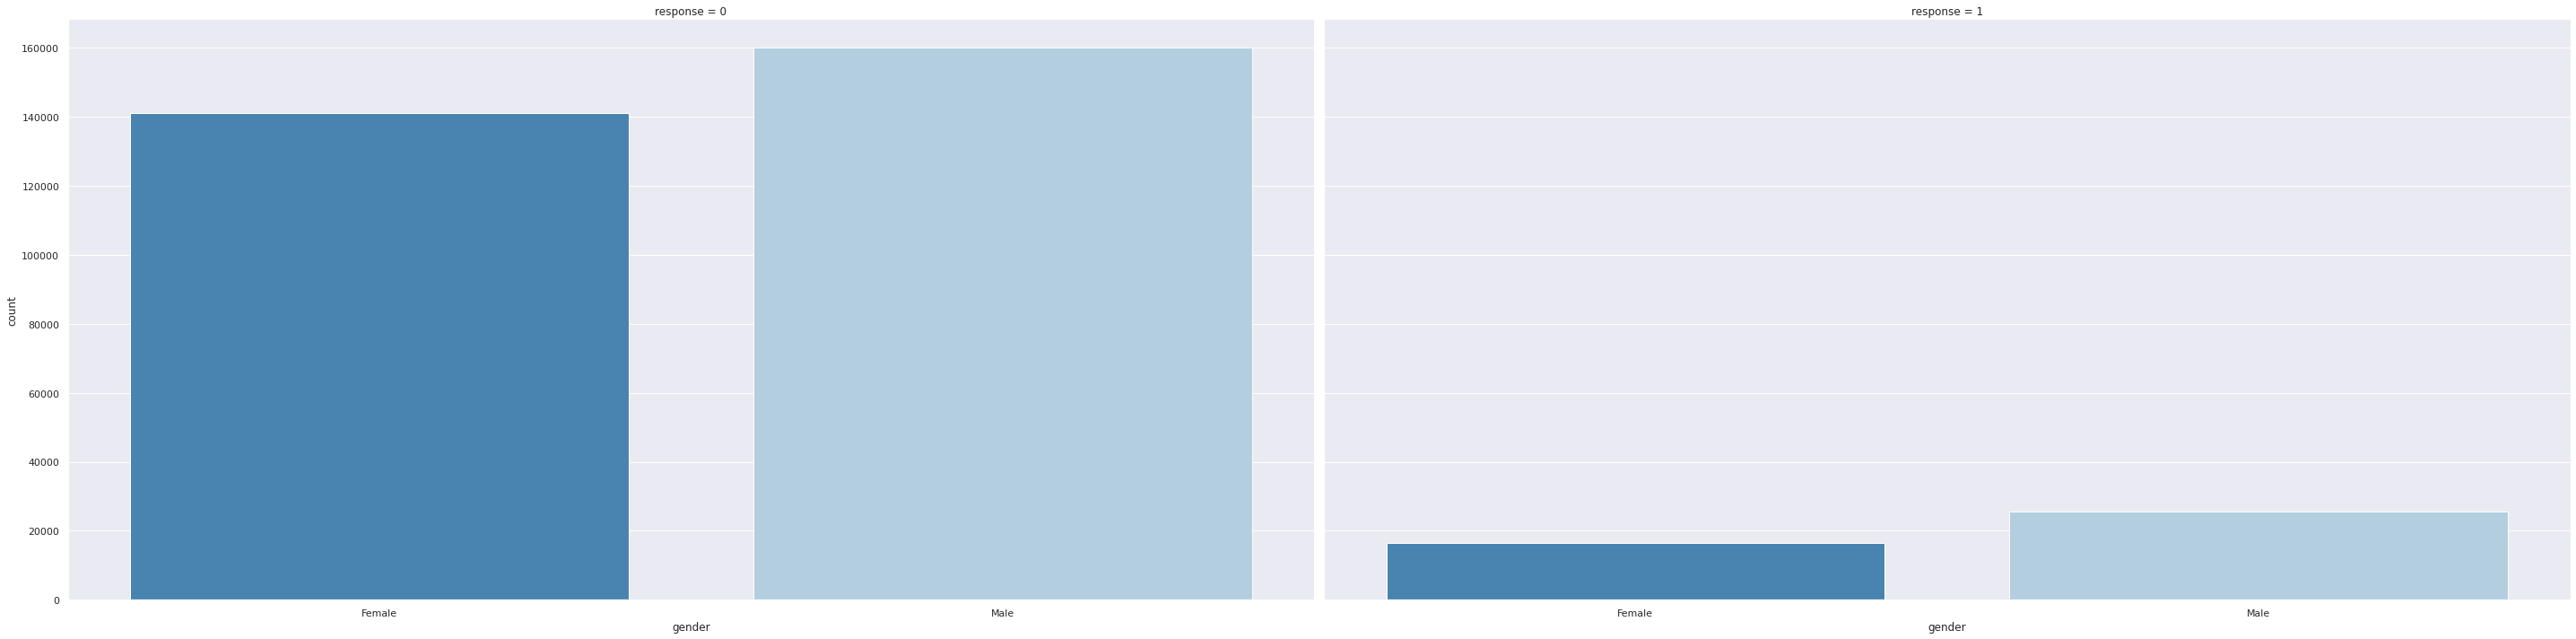

In [18]:
df_aux = train_set.groupby( ['gender', 'response'] )[[ 'id' ]].count().rename( columns = {'id' : 'count'} ).reset_index()
ax = sns.catplot(
    data = df_aux, x='gender', y='count', col = 'response',
    kind = 'bar', height=10, aspect = 2, 
    palette = 'Blues_r'
);

display('Nota-se que em ambos os casos de resposta, há mais pessoas do sexo masculino não demonstrando correlação forte entre "gender | response"')

#### Damage x Response

'Nota-se, que a quantidade quase absoluta de pessoas que demonstraram interesse em seguros, já tiveram seus carros "danificados" no passado, demonstrando fortíssima correlação entre as variáveis'

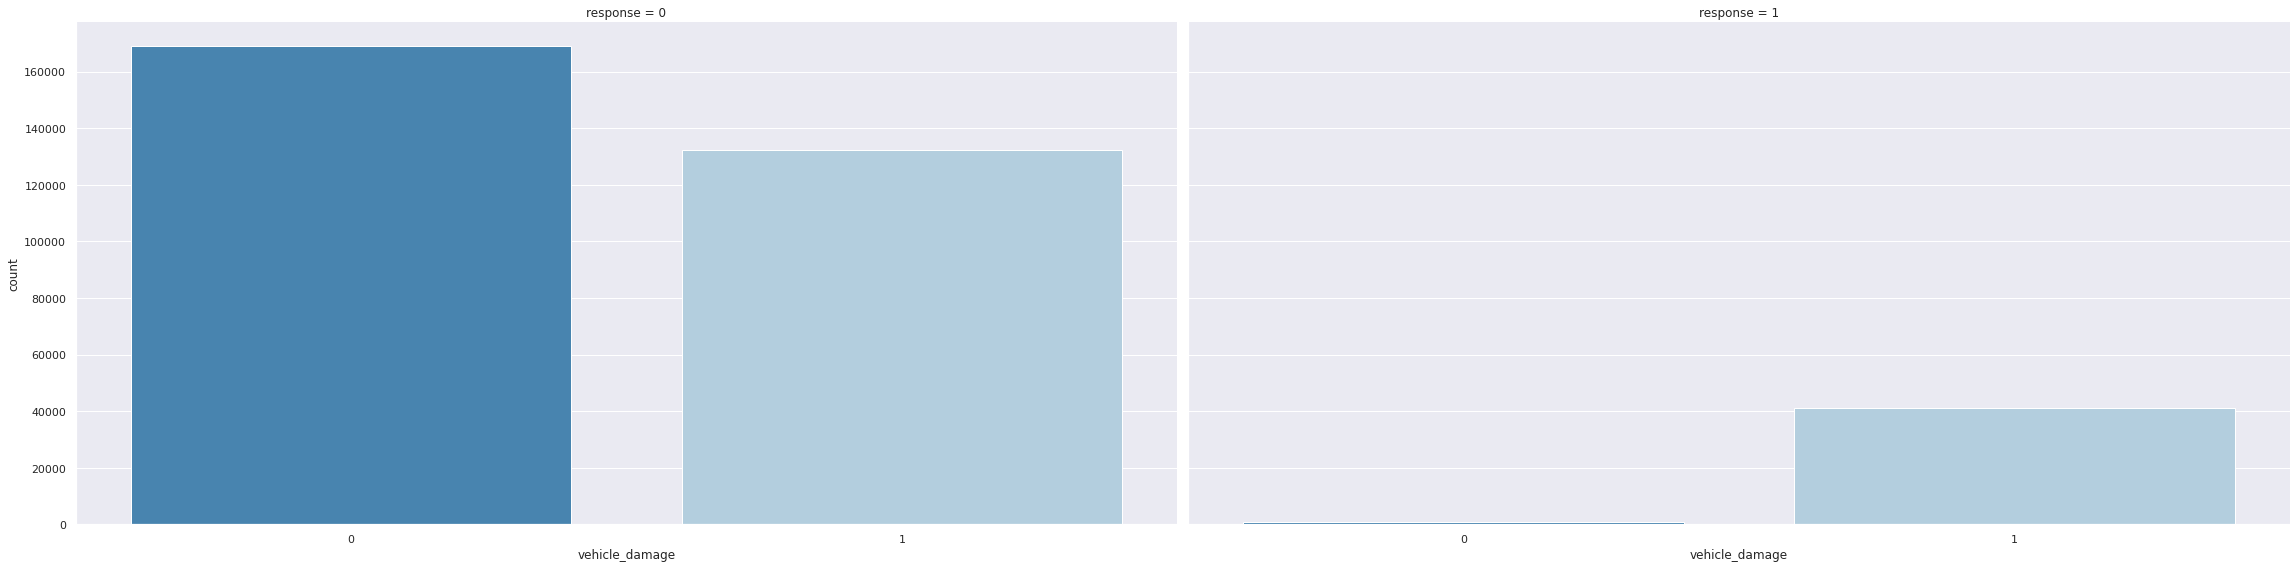

In [19]:
df_aux=train_set.groupby(['vehicle_damage','response'])[['id']].count().rename(columns={'id':'count'}).reset_index()
ax = sns.catplot(
    data = df_aux, 
    x = 'vehicle_damage', y = 'count', col = 'response',
    kind = 'bar', 
    height = 8, aspect = 2,
    palette = 'Blues_r'
);

display('Nota-se, que a quantidade quase absoluta de pessoas que demonstraram interesse em seguros, já tiveram seus carros "danificados" no passado, demonstrando fortíssima correlação entre as variáveis')

#### Previously Insured x Response

'Nota-se que em quase totalidade, os donos de veículos não assegurados demonstram maior interesse na proposta, demonstrando fortíssima correlação (negativa) entre as variáveis '

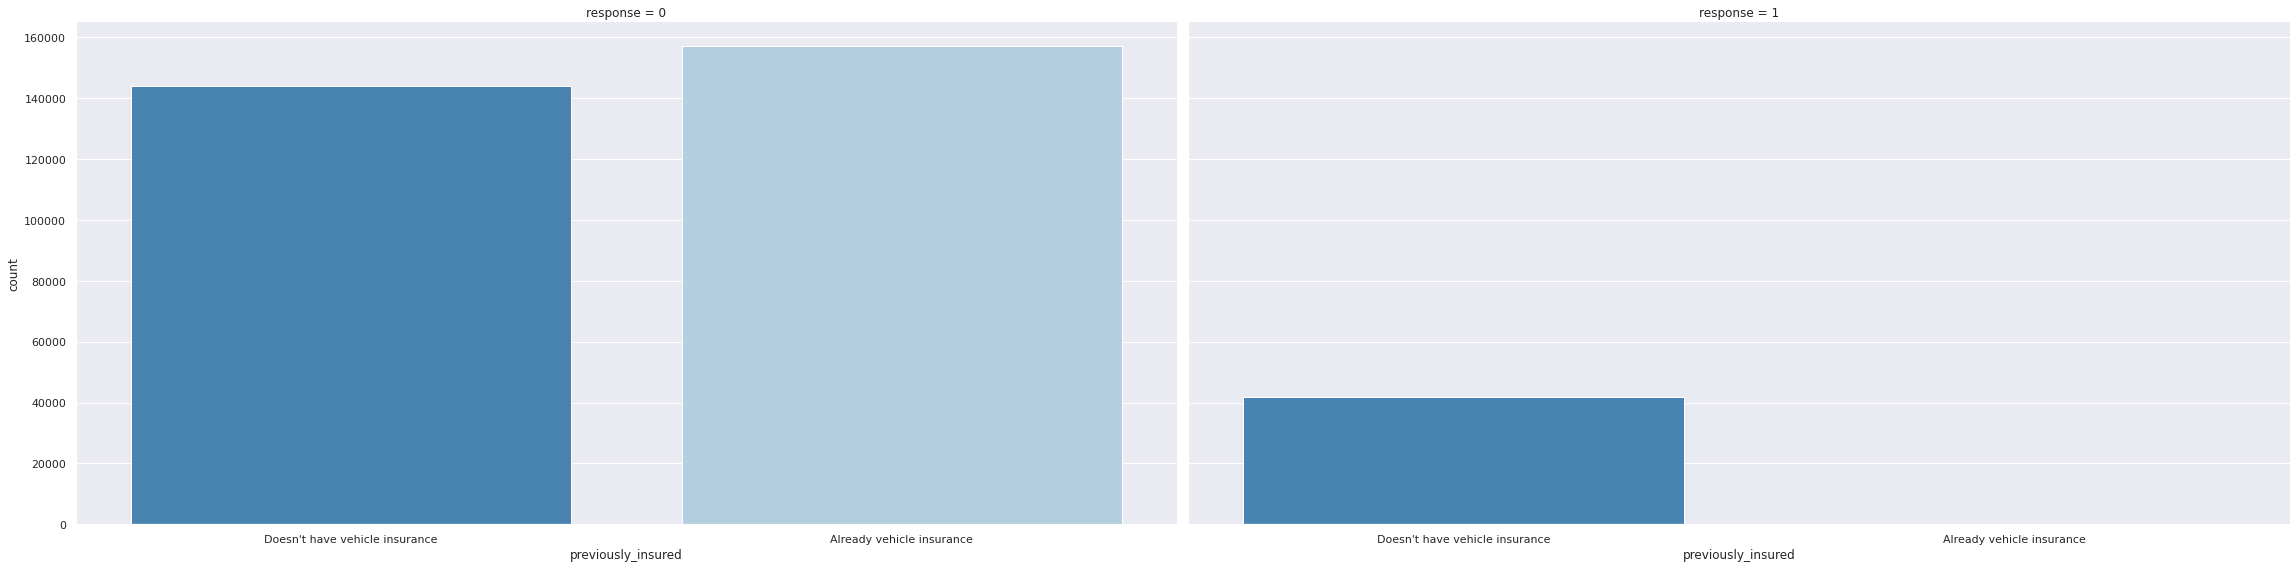

In [20]:
df_aux = train_set.groupby( ['previously_insured', 'response'] )[['id']].count().rename(columns={'id':'count'}).reset_index()
df_aux

ax = sns.catplot(
    data = df_aux, 
    x='previously_insured', y='count', col='response',
    kind = 'bar', height = 8, aspect = 2,
    palette='Blues_r'   
);
ax.set_xticklabels(["Doesn't have vehicle insurance", "Already vehicle insurance"]);
display('Nota-se que em quase totalidade, os donos de veículos não assegurados demonstram maior interesse na proposta, demonstrando fortíssima correlação (negativa) entre as variáveis ')

#### Vehicle age x Response

In [21]:
train_set.vehicle_age.unique()

array(['< 1 Year', '1-2 Year', '> 2 Years'], dtype=object)

'Apresar de seguir uma tendência geral dos dados, nota-se que donos de carros entre 1~2 anos, tendem a se interessar mais pela proposta.'

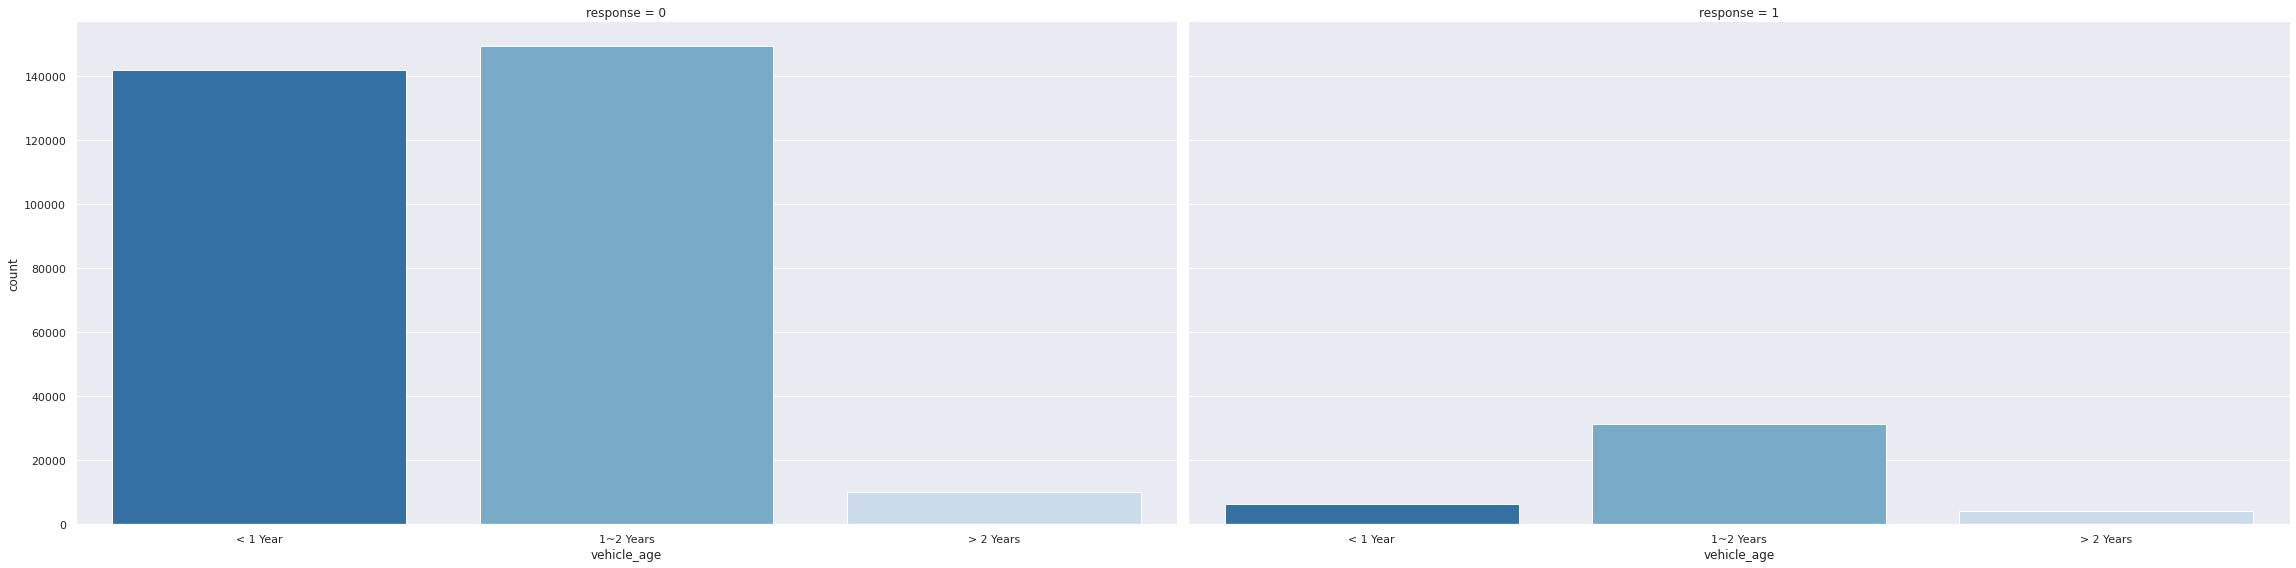

In [22]:
df_aux = train_set.groupby( ['vehicle_age', 'response'] )[['id']].count().rename( columns={'id':'count'} ).reset_index()

ax = sns.catplot(
    data    = df_aux,
    x       = 'vehicle_age', y = 'count', col = 'response', 
    height  = 8, aspect = 2, kind='bar',
    palette = 'Blues_r',
    order=['< 1 Year', '1-2 Year', '> 2 Years']
);
ax.set_xticklabels( ['< 1 Year', '1~2 Years', '> 2 Years'] );
display("Apresar de seguir uma tendência geral dos dados, nota-se que donos de carros entre 1~2 anos, tendem a se interessar mais pela proposta.")

### 6.2 Analysis of features isolated

#### Annual Premium Distribuition

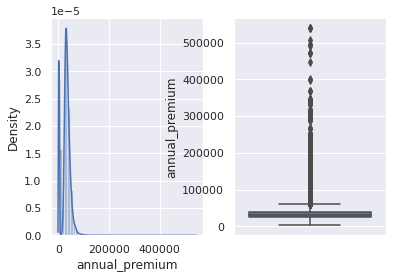

In [23]:
spec = gridspec.GridSpec(1,2)

plt.subplot(spec[0,0])
ax1 = sns.distplot(
    train_set.annual_premium
);

plt.subplot(spec[0,1])
ax = sns.boxplot(
    data=train_set, y='annual_premium'
);

## 7. Data Encoding | Normalization 

### Bkp

In [17]:
train_set_n = train_set.copy()

### Standardization

In [18]:
ss = StandardScaler()

#annual_premium
train_set_n['annual_premium'] = ss.fit_transform( train_set_n[['annual_premium']].values )

### Rescaling

In [19]:
mms_age     = MinMaxScaler()
mms_vintage = MinMaxScaler()

#age
train_set_n['age'] = mms_age.fit_transform( train_set_n[['age']].values )

#vintage
train_set_n['vintage'] = mms_vintage.fit_transform( train_set_n[['vintage']].values )


### Encodeing

In [20]:
#driving license      --- It already has encoding
#previously_insured   --- It already has encoding

### Target Encoding
#region_code          --- One Hot Encoding ( As there are many coders, it doesn't apply ) | Frequency Encoder | Target Encoding ( In Use ) | Wighted Target Encoding 
target_enc_region_code = train_set_n.groupby( 'region_code' )['response'].mean()
train_set_n.loc[:, 'region_code'] = train_set_n['region_code'].map( target_enc_region_code )
#gender               --- One Hot Encoding ( In Use ) | Order Encoding | Frequency Encoder
target_gender = train_set_n.groupby( 'gender' )['response'].mean()
train_set_n.loc[:, 'gender'] = train_set_n['gender'].map( target_gender )

### One Hot Encoding
#vehicle_age          --- One Hot Encoding ( In Use ) | Order Encoding | Frequency Encoder
train_set_n = pd.get_dummies( train_set_n, prefix = 'vehicle_age', columns = ['vehicle_age'] )

### Frequency Encoding
#policy_sales_channel --- Target Encoding | Frequency Encoder ( In use )
freq_policy_sales_chanel = train_set_n.groupby( 'policy_sales_channel' ).size() / len(train_set_n)
train_set_n.loc[:, 'policy_sales_channel'] = train_set_n['policy_sales_channel'].map( freq_policy_sales_chanel )

## 8. Training test Split

In [21]:
x = train_set_n.drop( columns=['response', 'id'] )
y = train_set_n.response

In [22]:
x_train, x_test, y_train, y_test = train_test_split( 
    x,y, 
    test_size = 0.2, 
    random_state = 11
)

## 9. Feature Selecttion

### Extra Trees Classifier

In [13]:
#model definition
etc = ExtraTreesClassifier( )
etc.fit(x_train, y_train)


ExtraTreesClassifier()

In [14]:
importances = etc.feature_importances_
std         = np.std( [etc.feature_importances_ for tree in etc.estimators_], axis=0 )
indices     = np.argsort( importances )[::-1]

df_aux = pd.DataFrame()
for i, j in zip( x_train, etc.feature_importances_ ):
    aux = pd.DataFrame( {'Feature' : i, 'Importance' : j}, index=[0] )
    df_aux = pd.concat( [df_aux, aux], axis=0 )
df_aux.sort_values( 'Importance', ascending=False, inplace=True )

df_aux

,Feature,Importance
0,vintage,0.272133
0,annual_premium,0.242220
0,age,0.166162
0,region_code,0.106254
0,vehicle_damage,0.074214
0,policy_sales_channel,0.060301
0,previously_insured,0.048451
0,vehicle_age_< 1 Year,0.014901
0,vehicle_age_1-2 Year,0.007180
0,gender,0.004757


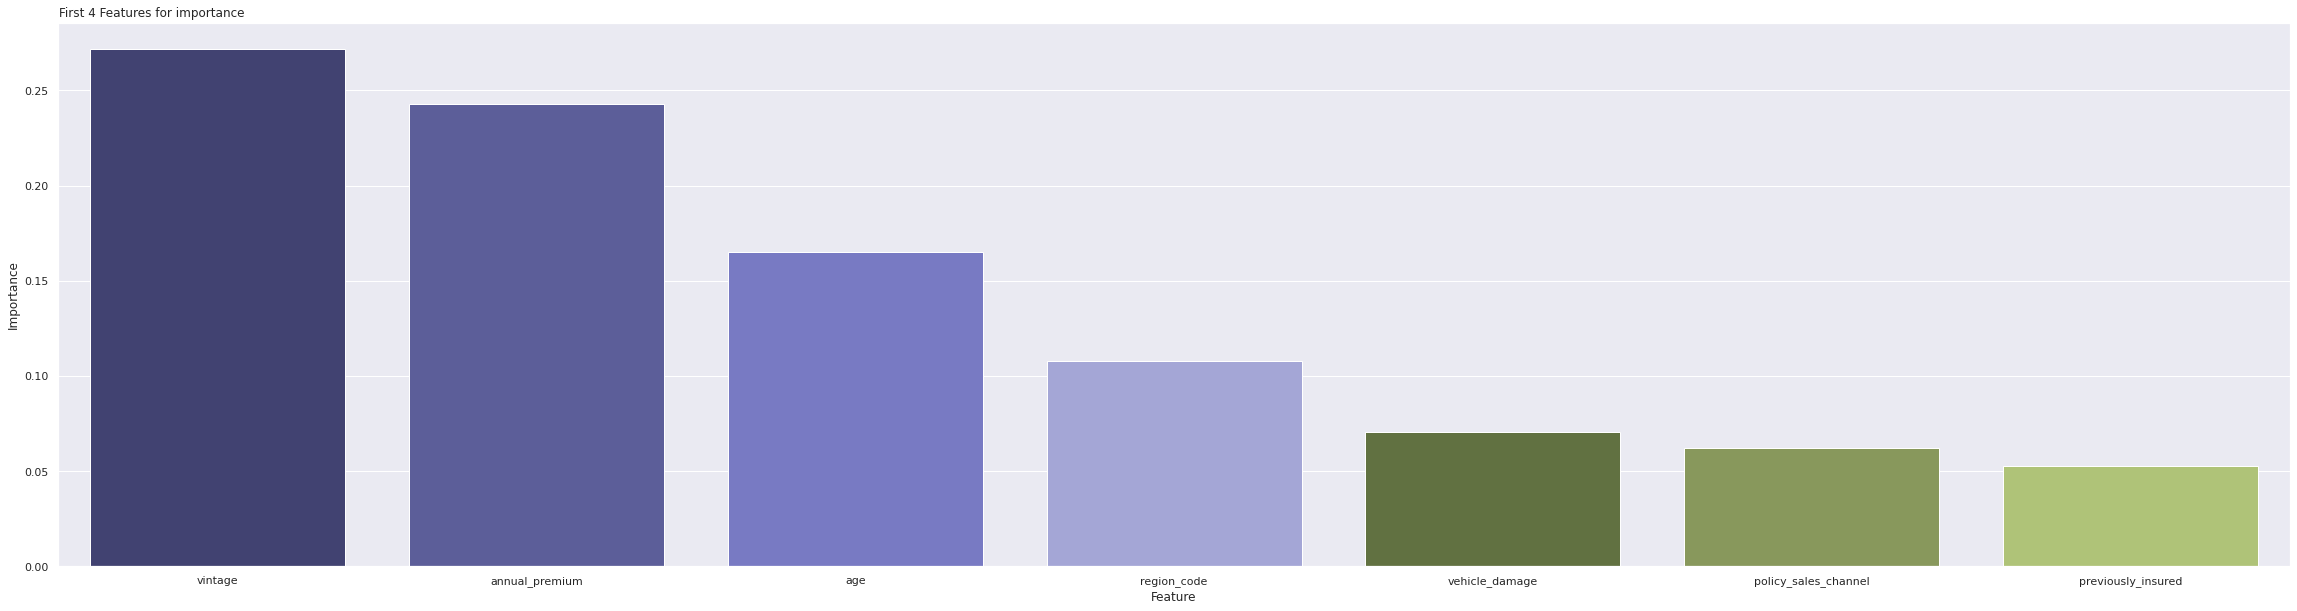

In [35]:
sns.barplot( 
    data = df_aux.head(7), x = 'Feature', y = 'Importance',
    palette='tab20b'
);
plt.title( 'First 4 Features for importance', x=0.042 );

In [15]:
cols_selected = list( df_aux['Feature'].head(7) )
cols_selected

['vintage',
 'annual_premium',
 'age',
 'region_code',
 'vehicle_damage',
 'policy_sales_channel',
 'previously_insured']

### Random Forest Classifier

In [102]:
rf = RandomForestClassifier()
rf.fit( x_train, y_train )

RandomForestClassifier()

In [103]:
cols = x_train.columns
fimport = rf.feature_importances_
order = np.argsort( fimport )[::-1]
df_aux = pd.DataFrame( zip( cols, fimport ), columns=['Features', 'Importance']  ).sort_values( by='Importance', ascending=False ).reset_index( drop=True )

In [104]:
df_aux

,Features,Importance
0,vintage,0.280803
1,annual_premium,0.251104
2,age,0.149117
3,region_code,0.096445
4,policy_sales_channel,0.071623
5,vehicle_damage,0.066322
6,previously_insured,0.054998
7,vehicle_age_< 1 Year,0.010829
8,gender,0.009693
9,vehicle_age_1-2 Year,0.006024


### Boruta 

In [146]:
x_train_boruta = x_train.values
y_train_boruta = y_train.values.ravel()

In [ ]:
#instancing Random forest regressor
rfr = RandomForestRegressor( n_jobs = -3, n_estimators=300 )

#instancing Boruta
boruta = BorutaPy( rfr, n_estimators='auto', verbose=2, random_state=50 ).fit( x_train_boruta, y_train_boruta )

### Best Features
cols_selected = boruta.support_.tolist()
cols_selected_boruta = x_train.iloc[:,cols_selected].columns.tolist()


In [148]:
cols_selected_boruta

['vehicle_damage']

### Apply Feature Selection

In [23]:
cols_selected = ['vintage',
 'annual_premium',
 'age',
 'region_code',
 'vehicle_damage',
 'policy_sales_channel',
 'previously_insured']

In [24]:
x_train_selected = x_train[cols_selected].copy()
x_test_selected = x_test[cols_selected].copy()

## 10. testing Machine Learning Models

### 10.1 Model testing

#### Random Forest Classifier

In [28]:
rfc    = RandomForestClassifier(n_estimators=300)
df_rf = cross_validation( 'Random Forest', rfc, x_train_selected, y_train, 10 )

#### Logistic Regression

In [30]:
lr    = LogisticRegression()
df_lr =  cross_validation( 'Logistic Regression', lr, x_train_selected, y_train, 10 )

#### KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=15)
df_knn =  cross_validation( 'KNeighbors Classifier', knn, x_train_selected, y_train, 10 )


#### Navie Bayes

In [31]:
gnb = GaussianNB()
df_gnb = cross_validation( 'Gaussian Navie Bayes', gnb, x_train_selected, y_train, 10 )

#### XGBoost

In [15]:
xgboost = xgb.XGBClassifier()
df_xgb = cross_validation( 'XGBoost', xgboost, x_train_selected, y_train, 10 )

#### Concat results

In [44]:
df_result = pd.concat( [df_rf, df_lr, df_knn, df_gnb, df_xgb] )
df_result.sort_values('ROC AUC Score CV', ascending=False, inplace=True)

In [19]:
df_result

,Model Name,ROC AUC Score CV,Precision,Recall
0,XGBoost,85.0% | +/- | 0.0,40.0% | +/- | 0.0,2.0% | +/- | 0.0
1,Random Forest,83.0% | +/- | 0.0,35.0% | +/- | 0.0,12.0% | +/- | 0.0
2,Gaussian Navie Bayes,83.0% | +/- | 0.0,25.0% | +/- | 0.0,98.0% | +/- | 0.0
3,Logistic Regression,82.0% | +/- | 0.0,0.0% | +/- | 0.0,0.0% | +/- | 0.0
4,KNeighbors Classifier,80.0% | +/- | 0.0,35.0% | +/- | 0.0,6.0% | +/- | 0.0


### 10.1 Understanding results

#### Random Forest result

In [72]:
rf = RandomForestClassifier()
rf.fit( x_train_selected, y_train )
pred_proba = rf.predict_proba( x_test_selected )[:,1]
pred = rf.predict( x_test_selected )


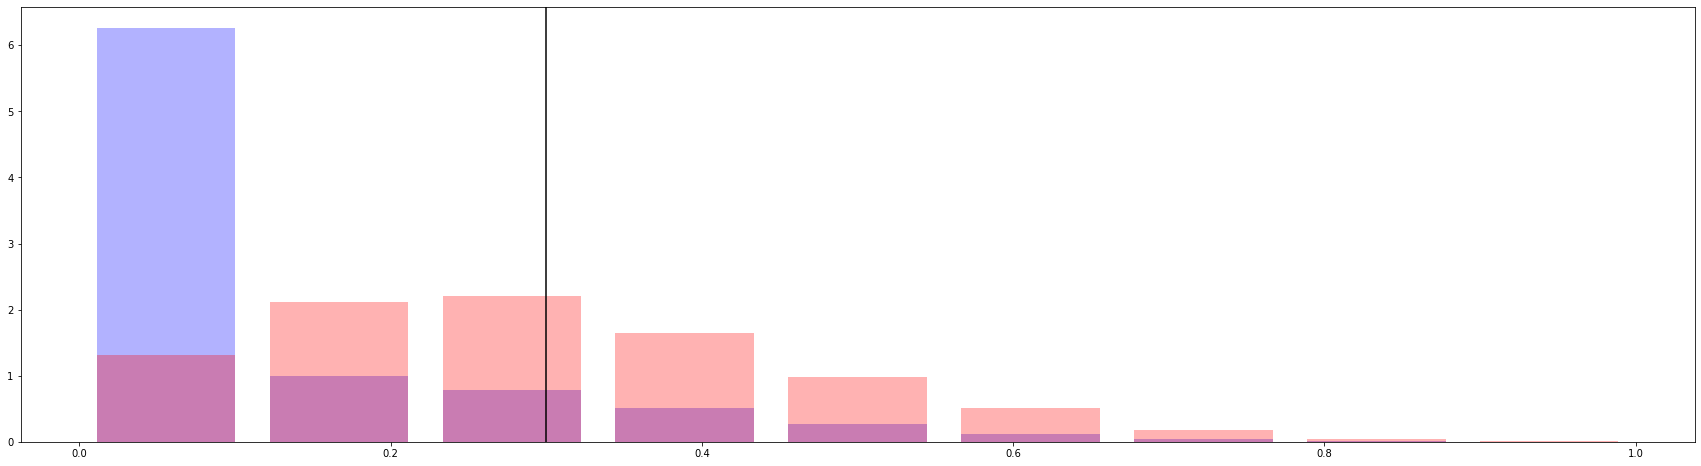

In [73]:
plt.figure( figsize = (30,8) );

plt.hist( pred_proba[y_test == 0], bins = np.linspace( 0,1,10 ), color = 'b', alpha = .3, density = True, rwidth = .8 );
plt.hist( pred_proba[y_test == 1], bins = np.linspace( 0,1,10 ), color = 'r', alpha = .3, density = True, rwidth = .8 );
plt.axvline( 0.3, color = 'k' );


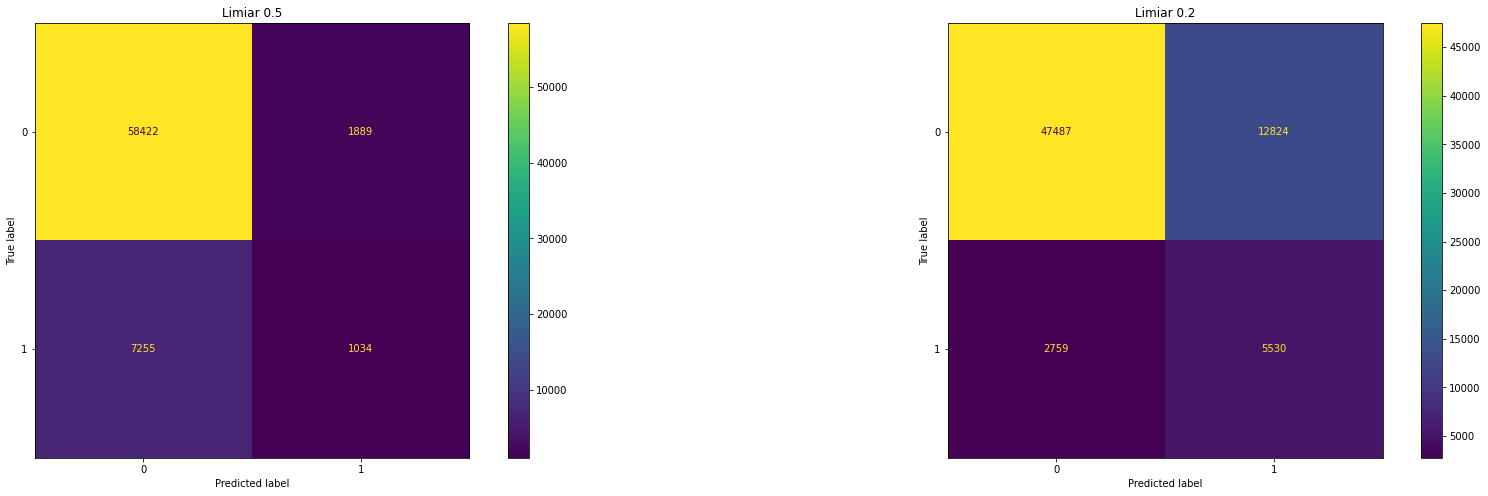

In [74]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure( figsize=( 30,8 ) )
ax = plt.subplot( 1,2,1 )
ConfusionMatrixDisplay.from_predictions( y_test, pred, ax=ax )
plt.title( 'Limiar 0.5' );

ax1 = plt.subplot( 1,2,2 )
ConfusionMatrixDisplay.from_predictions( y_test, pred_proba>0.2, ax=ax1 )
plt.title( 'Limiar 0.2' );

#### Logistic Regression result

In [75]:
lr = LogisticRegression(  )
lr.fit( x_train_selected, y_train )
pred_proba = lr.predict_proba( x_test_selected )[:,1]
pred = lr.predict( x_test_selected )


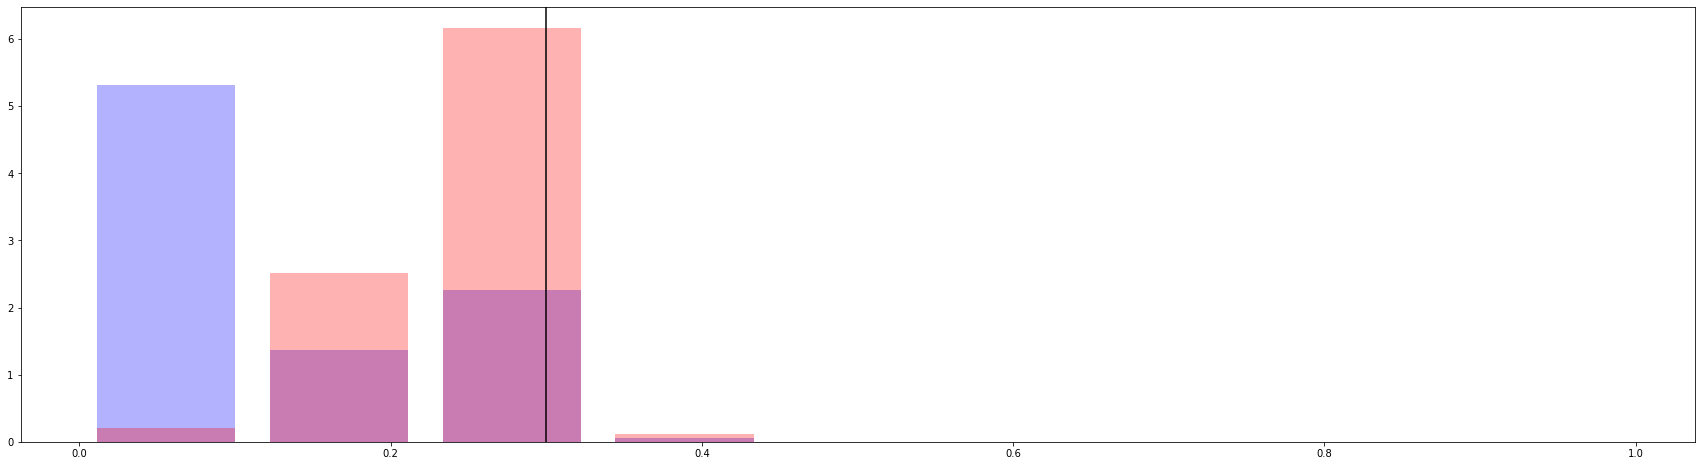

In [76]:
plt.figure( figsize = (30,8) );

plt.hist( pred_proba[y_test == 0], bins = np.linspace( 0,1,10 ), color = 'b', alpha = .3, density = True, rwidth = .8 );
plt.hist( pred_proba[y_test == 1], bins = np.linspace( 0,1,10 ), color = 'r', alpha = .3, density = True, rwidth = .8 );
plt.axvline( 0.3, color = 'k' );


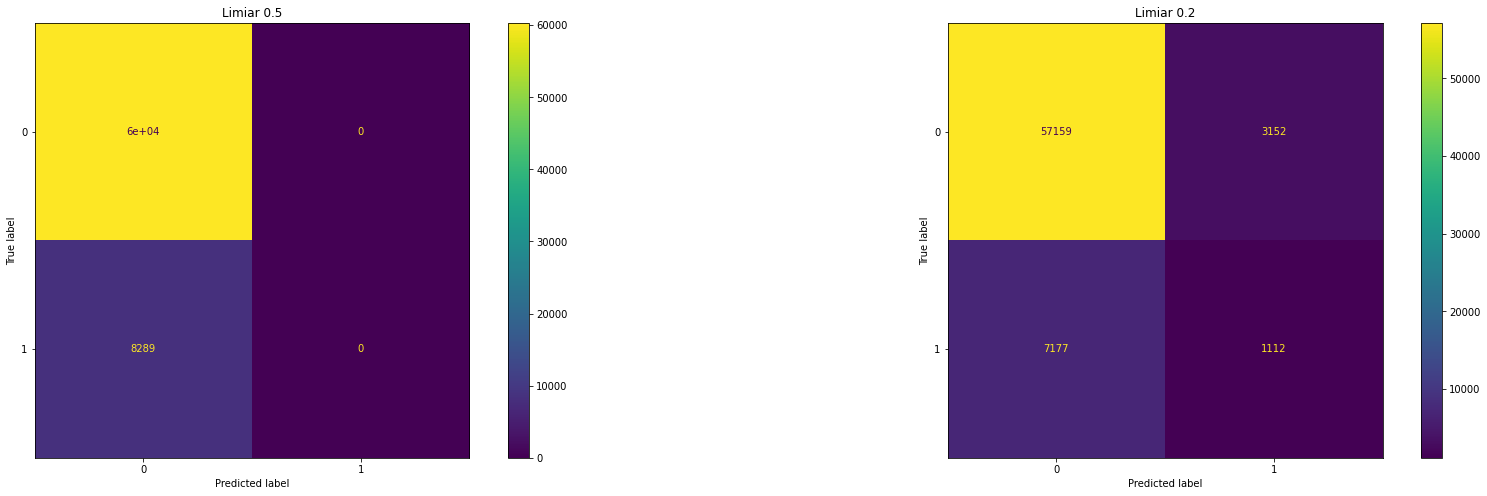

In [82]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure( figsize=( 30,8 ) )
ax = plt.subplot( 1,2,1 )
ConfusionMatrixDisplay.from_predictions( y_test, pred, ax=ax )
plt.title( 'Limiar 0.5' );

ax1 = plt.subplot( 1,2,2 )
ConfusionMatrixDisplay.from_predictions( y_test, pred_proba>0.3, ax=ax1 )
plt.title( 'Limiar 0.3' );

#### XGBoost result

In [20]:
xgboost = xgb.XGBClassifier(  )
xgboost.fit( x_train_selected, y_train )
pred_proba = xgboost.predict_proba( x_test_selected )[:,1]
pred = xgboost.predict( x_test_selected )

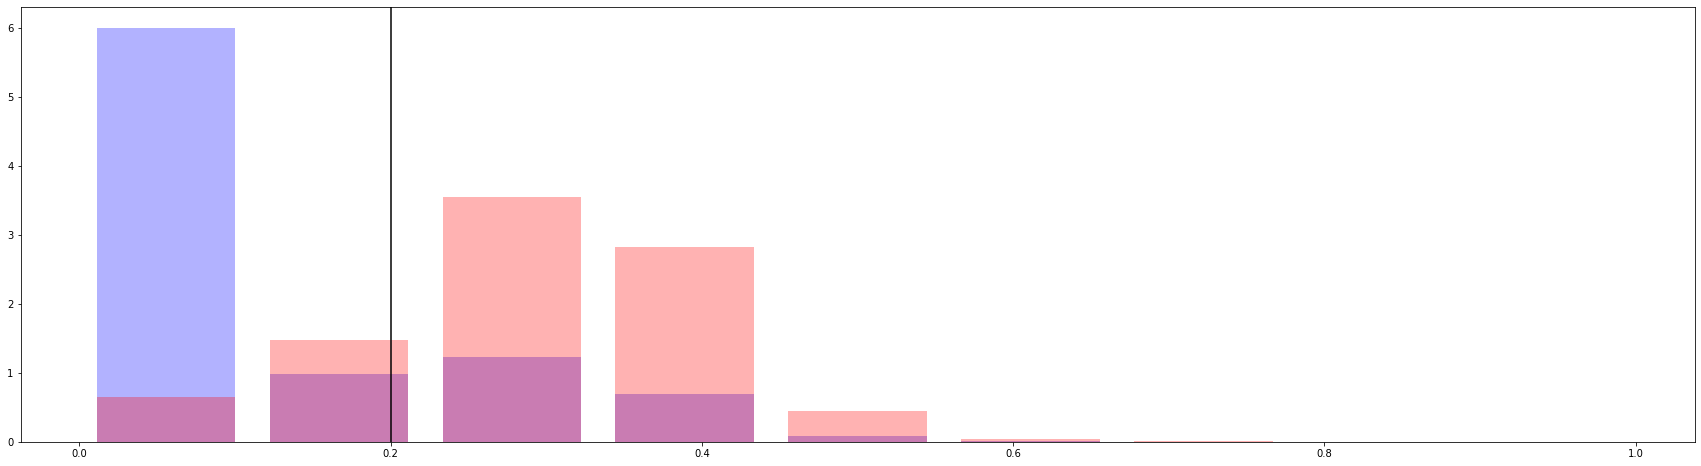

In [28]:
plt.figure( figsize = (30,8) );

plt.hist( pred_proba[y_test == 0], bins = np.linspace( 0,1,10 ), color = 'b', alpha = .3, density = True, rwidth = .8 );
plt.hist( pred_proba[y_test == 1], bins = np.linspace( 0,1,10 ), color = 'r', alpha = .3, density = True, rwidth = .8 );
plt.axvline( 0.2, color = 'k' );

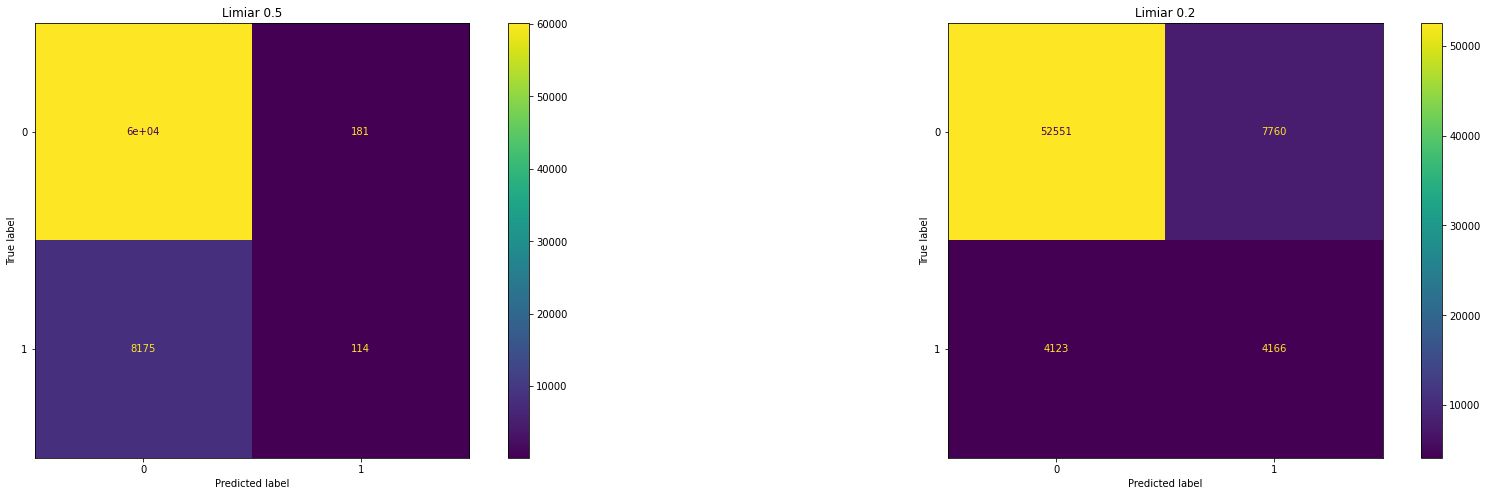

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure( figsize=( 30,8 ) )
ax = plt.subplot( 1,2,1 )
ConfusionMatrixDisplay.from_predictions( y_test, pred, ax=ax )
plt.title( 'Limiar 0.5' );

ax1 = plt.subplot( 1,2,2 )
ConfusionMatrixDisplay.from_predictions( y_test, pred_proba>0.3, ax=ax1 )
plt.title( 'Limiar 0.2' );

## 11. Data Modelling and Evaluation

### 11.1 Random Forest

#### 11.1.1 Fine Tuning

In [31]:
random_search = {
    'criterion'         : ['entropy', 'gini'],
    'max_depth'         : [2, 4, 6, 8, 10],
    'min_samples_split' : [5, 7, 10],
    'n_estimators'      : [200, 350]
}

rfc = RandomForestClassifier()
model = RandomizedSearchCV( 
    estimator = rfc, param_distributions = random_search, n_iter = 10,
    cv = 4, verbose = 1, random_state = 11, n_jobs = -3
)

model.fit( x_train_selected, y_train )

Fitting 4 folds for each of 10 candidates, totalling 40 fits


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-3,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 4, 6, 8, 10],
                                        'min_samples_split': [5, 7, 10],
                                        'n_estimators': [200, 350]},
                   random_state=11, verbose=1)

In [33]:
best_params = {'n_estimators': 200,
 'min_samples_split': 7,
 'max_depth': 4,
 'criterion': 'gini'}

#### 11.1.2 Evaluation

In [17]:
rfcft = RandomForestClassifier(
     n_estimators = 200,
     min_samples_split = 7,
     max_depth = 4,
     criterion = 'gini'
)

In [ ]:
df_rf = cross_validation( 'Random Forest FT', rfcft, x_train_selected, y_train, 10  )

In [21]:
rfcft.fit( x_train_selected, y_train )
pred_proba = rfcft.predict_proba( x_test_selected )[:,1]
pred = rfcft.predict( x_test_selected )


In [22]:
display( df_rf )
print( classification_report( y_test, pred ) )

,Model Name,ROC AUC Score CV,Precision,Recall
0,Random Forest FT,84.0% | +/- | 0.0,0.0% | +/- | 0.0,0.0% | +/- | 0.0


              precision    recall  f1-score   support

           0       0.88      1.00      0.94     60311
           1       0.00      0.00      0.00      8289

    accuracy                           0.88     68600
   macro avg       0.44      0.50      0.47     68600
weighted avg       0.77      0.88      0.82     68600



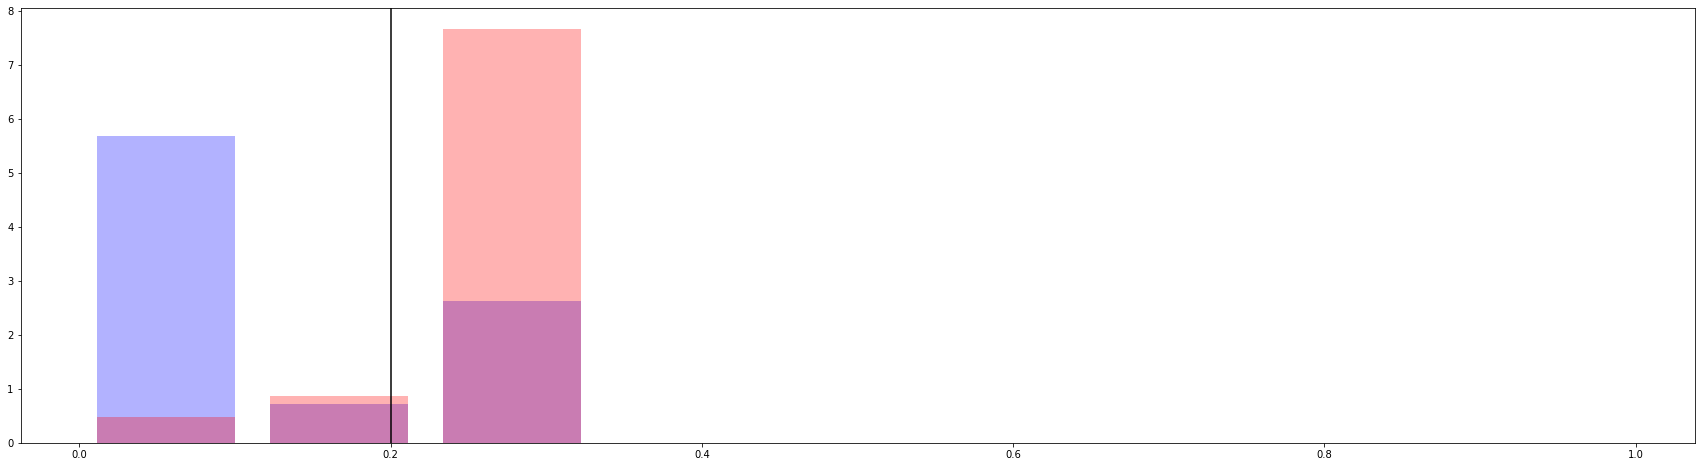

In [69]:
plt.figure( figsize = (30,8) );

plt.hist( pred_proba[y_test == 0], bins = np.linspace( 0,1,10 ), color = 'b', alpha = .3, density = True, rwidth = .8 );
plt.hist( pred_proba[y_test == 1], bins = np.linspace( 0,1,10 ), color = 'r', alpha = .3, density = True, rwidth = .8 );
plt.axvline( 0.2, color = 'k' );


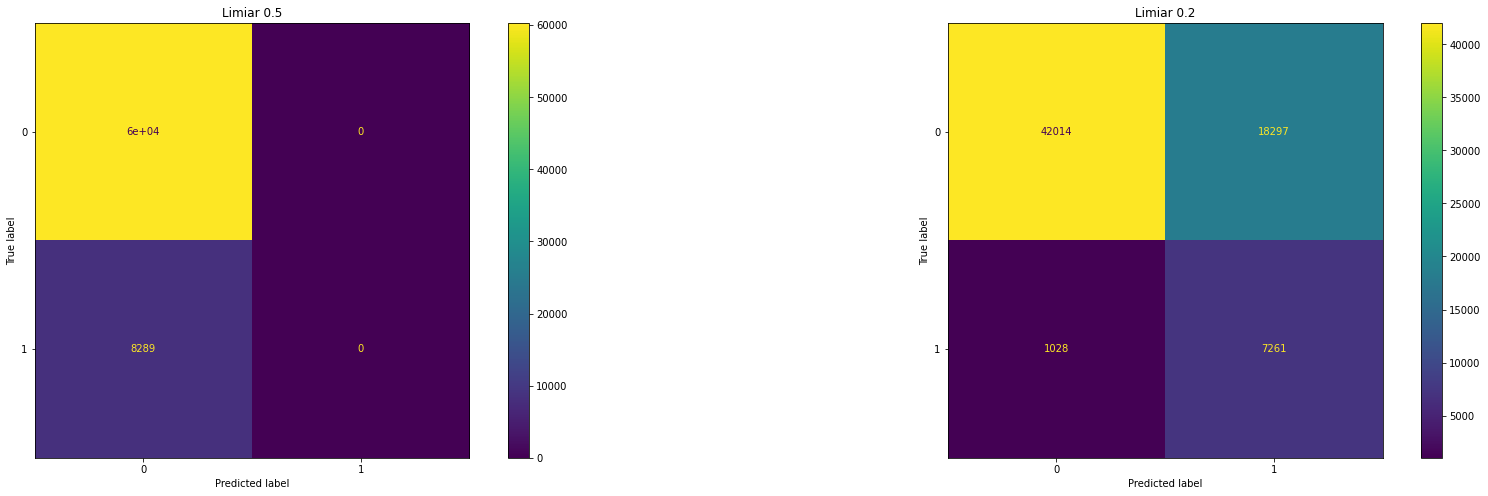

In [68]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure( figsize=( 30,8 ) )
ax = plt.subplot( 1,2,1 )
ConfusionMatrixDisplay.from_predictions( y_test, pred, ax=ax )
plt.title( 'Limiar 0.5' );

ax1 = plt.subplot( 1,2,2 )
ConfusionMatrixDisplay.from_predictions( y_test, pred_proba>0.2, ax=ax1 )
plt.title( 'Limiar 0.2' );

#### 11.1.3 Save Model

In [4]:
pickle.dump( rfcft, open( '../data/Models/rand_forest.sav', 'wb' ) )

NameError: name 'rfcft' is not defined

### 11.2 XGBoost

#### 11.2.1 Fine Tuning

In [90]:
param= {
'gamma'            : [1, 9],
'reg_alpha'        : [40, 180, 1],
'reg_lambda'       : [0, 1],
'colsample_bytree' : [0.3,0.7,0.9],
'min_child_weight' : [3,8,15],
'n_estimators'     : [100, 200, 300],
'seed'             : [0],
}
_MAX_EVAL = 10

In [92]:
final_result = pd.DataFrame()
for i in range( _MAX_EVAL ):
    #Choose values for parameters randomly
    hp = {k: random.sample(v,1)[0] for k,v in param.items() }
    print(hp)


    xgb_model = xgb.XGBClassifier(
        gamma            = hp['gamma'],
        reg_alpha        = hp['reg_alpha'],
        reg_lambda       = hp['reg_lambda'],
        colsample_bytree = hp['colsample_bytree'],
        min_child_weight = hp['min_child_weight'],
        n_estimators     = hp['n_estimators'],
        seed             = hp['seed'],
        
    )
    
    #Performance
    result = cross_validation(i, xgb_model, x_train_selected, y_train, 10 )
    final_result = pd.concat([final_result, result])

{'gamma': 9, 'reg_alpha': 40, 'reg_lambda': 0, 'colsample_bytree': 0.3, 'min_child_weight': 15, 'n_estimators': 200, 'seed': 0}
{'gamma': 1, 'reg_alpha': 1, 'reg_lambda': 0, 'colsample_bytree': 0.9, 'min_child_weight': 15, 'n_estimators': 200, 'seed': 0}
{'gamma': 1, 'reg_alpha': 180, 'reg_lambda': 1, 'colsample_bytree': 0.3, 'min_child_weight': 15, 'n_estimators': 100, 'seed': 0}
{'gamma': 9, 'reg_alpha': 1, 'reg_lambda': 0, 'colsample_bytree': 0.7, 'min_child_weight': 8, 'n_estimators': 100, 'seed': 0}
{'gamma': 9, 'reg_alpha': 180, 'reg_lambda': 1, 'colsample_bytree': 0.9, 'min_child_weight': 8, 'n_estimators': 300, 'seed': 0}
{'gamma': 1, 'reg_alpha': 180, 'reg_lambda': 0, 'colsample_bytree': 0.3, 'min_child_weight': 15, 'n_estimators': 100, 'seed': 0}
{'gamma': 1, 'reg_alpha': 180, 'reg_lambda': 1, 'colsample_bytree': 0.9, 'min_child_weight': 8, 'n_estimators': 300, 'seed': 0}
{'gamma': 9, 'reg_alpha': 180, 'reg_lambda': 0, 'colsample_bytree': 0.9, 'min_child_weight': 3, 'n_estima

In [97]:
final_result.sort_values( 'ROC AUC Score CV', ascending=False ).head(2)

,Model Name,ROC AUC Score CV,Precision,Recall
0,3,86.0% | +/- | 0.0,50.0% | +/- | 0.0,0.0% | +/- | 0.0
0,8,86.0% | +/- | 0.0,52.0% | +/- | 0.0,1.0% | +/- | 0.0


#### 11.2.2 Evaluation

In [101]:
xgb_model = xgb.XGBClassifier(
    gamma            = 9,
    reg_alpha        = 180,
    reg_lambda       = 0,
    colsample_bytree = 0.9,
    min_child_weight = 3,
    n_estimators     = 100,
    seed             = 0,
)

In [102]:
xgb_model.fit( x_train_selected, y_train )
pred_proba = xgb_model.predict_proba( x_test_selected )[:,1]
pred = xgb_model.predict( x_test_selected )

In [103]:
print( classification_report( y_test, pred ) )

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     60311
           1       0.00      0.00      0.00      8289

    accuracy                           0.88     68600
   macro avg       0.44      0.50      0.47     68600
weighted avg       0.77      0.88      0.82     68600



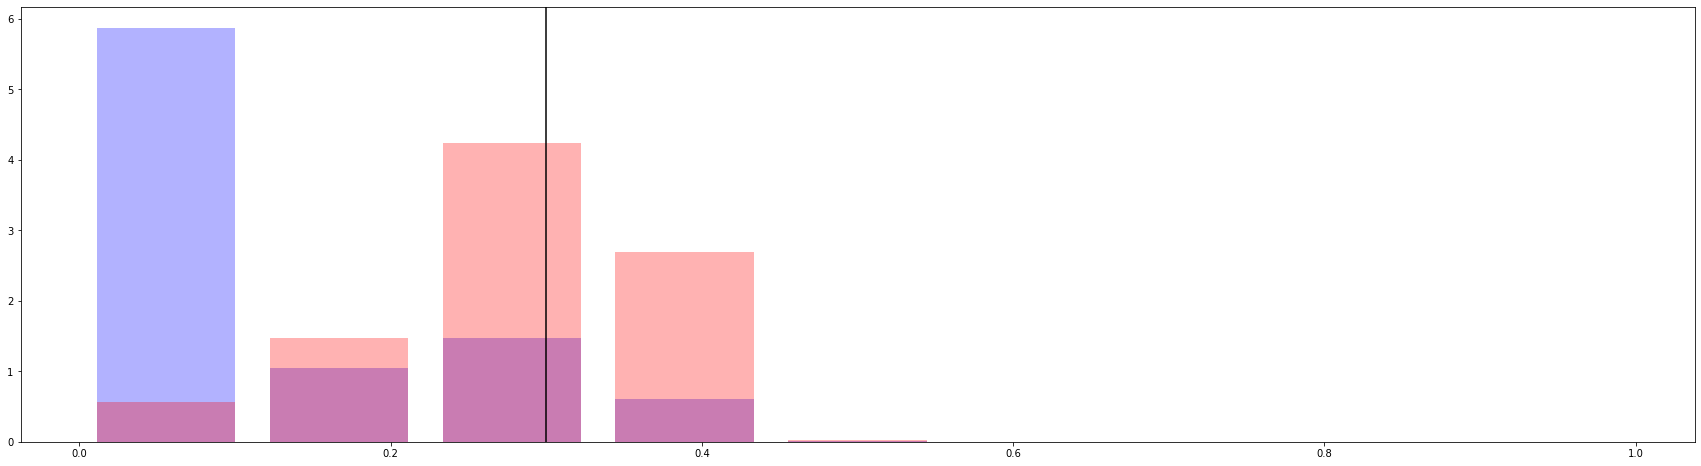

In [107]:
plt.figure( figsize = (30,8) );

plt.hist( pred_proba[y_test == 0], bins = np.linspace( 0,1,10 ), color = 'b', alpha = .3, density = True, rwidth = .8 );
plt.hist( pred_proba[y_test == 1], bins = np.linspace( 0,1,10 ), color = 'r', alpha = .3, density = True, rwidth = .8 );
plt.axvline( 0.3, color = 'k' );


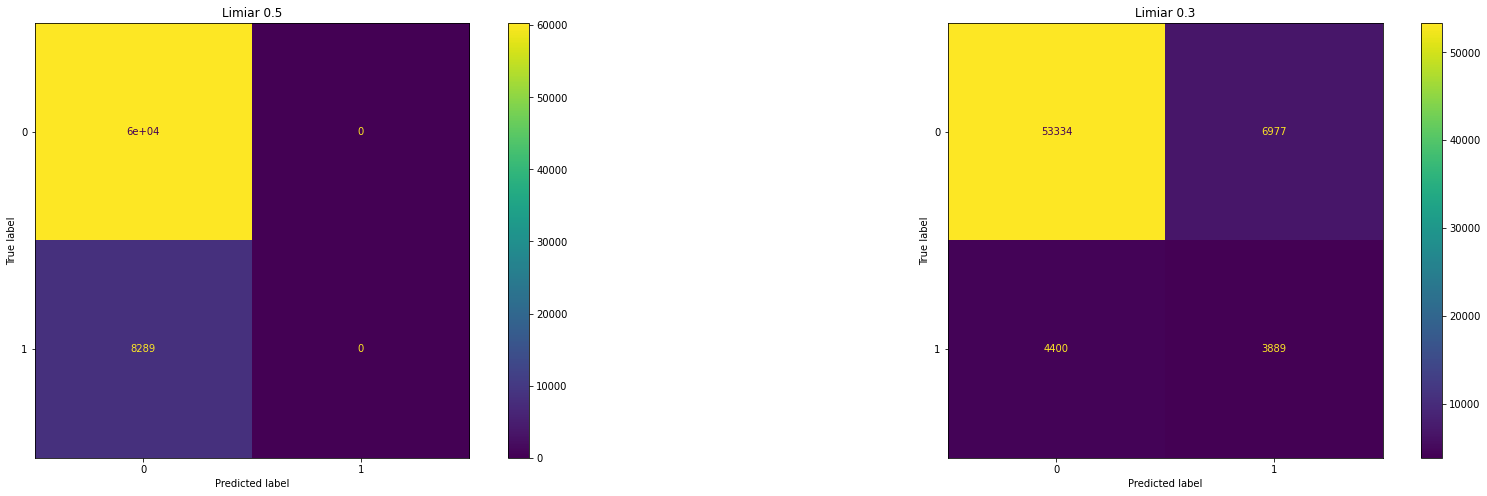

In [112]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure( figsize=( 30,8 ) )
ax = plt.subplot( 1,2,1 )
ConfusionMatrixDisplay.from_predictions( y_test, pred, ax=ax )
plt.title( 'Limiar 0.5' );

ax1 = plt.subplot( 1,2,2 )
ConfusionMatrixDisplay.from_predictions( y_test, pred_proba>0.3, ax=ax1 )
plt.title( 'Limiar 0.3' );

#### 12.2.3 Save Model

In [113]:
pickle.dump( xgb_model, open( '../data/Models/xgb_model.sav', 'wb' ) )

## 12. Test Best Model (XGBoost)

#### Data Prepare

In [25]:
x_tr = data_preprocessing( train_set )
x_te = data_preprocessing( test_set )


x_te.set_index('id', inplace=True)

In [26]:
x_tr = x_tr[cols_selected]
y_tr = train_set.response

x_te = x_te[cols_selected]
y_te = test_set.response

### 12.1 First Tests

In [27]:
xgb_model = pickle.load( open( '../data/Models/xgb_model.sav', 'rb' ) )


In [28]:
xgb_model.fit( x_tr, y_tr )

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=9, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=180, reg_lambda=0, ...)

In [29]:
pred_proba = xgb_model.predict_proba( x_te )[:,1]
pred = xgb_model.predict( x_te )

In [22]:
print( classification_report( y_te, pred ) )

              precision    recall  f1-score   support

           0       0.87      1.00      0.93     33313
           1       0.00      0.00      0.00      4798

    accuracy                           0.87     38111
   macro avg       0.44      0.50      0.47     38111
weighted avg       0.76      0.87      0.82     38111



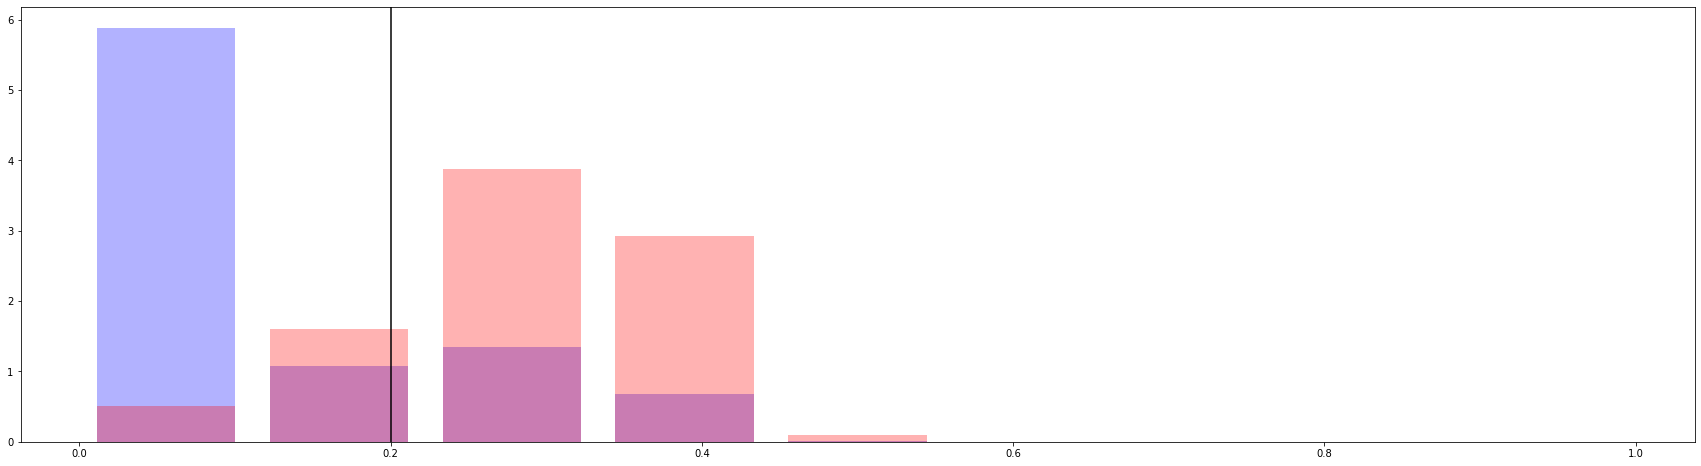

In [137]:
plt.figure( figsize = (30,8) );

plt.hist( pred_proba[y_te == 0], bins = np.linspace( 0,1,10 ), color = 'b', alpha = .3, density = True, rwidth = .8 );
plt.hist( pred_proba[y_te == 1], bins = np.linspace( 0,1,10 ), color = 'r', alpha = .3, density = True, rwidth = .8 );
plt.axvline( 0.2, color = 'k' );

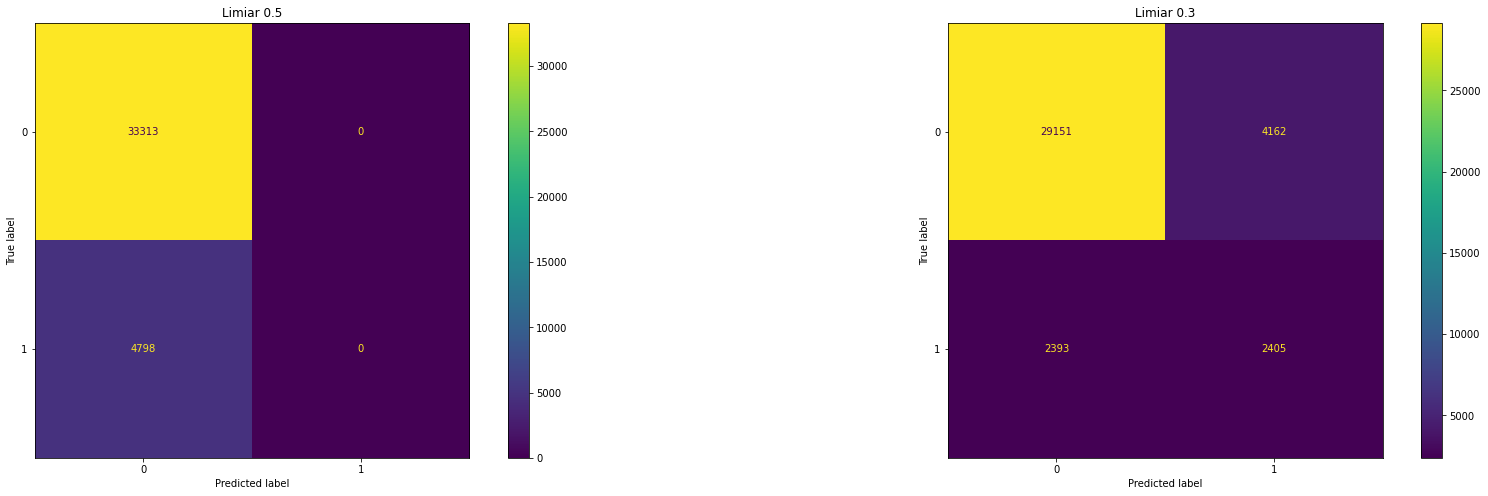

In [146]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure( figsize=( 30,8 ) )
ax = plt.subplot( 1,2,1 )
ConfusionMatrixDisplay.from_predictions( y_te, pred, ax=ax )
plt.title( 'Limiar 0.5' );

ax1 = plt.subplot( 1,2,2 )
ConfusionMatrixDisplay.from_predictions( y_te, pred_proba>0.3, ax=ax1 )
plt.title( 'Limiar 0.3' );

### 12.2 Cumulative Gain| Lift

#### 12.2.1 XGBoost

In [30]:
y_hat = xgb_model.predict_proba( x_te )
y_pred = xgb_model.predict( x_te )

'Acuracy: 87.4% '

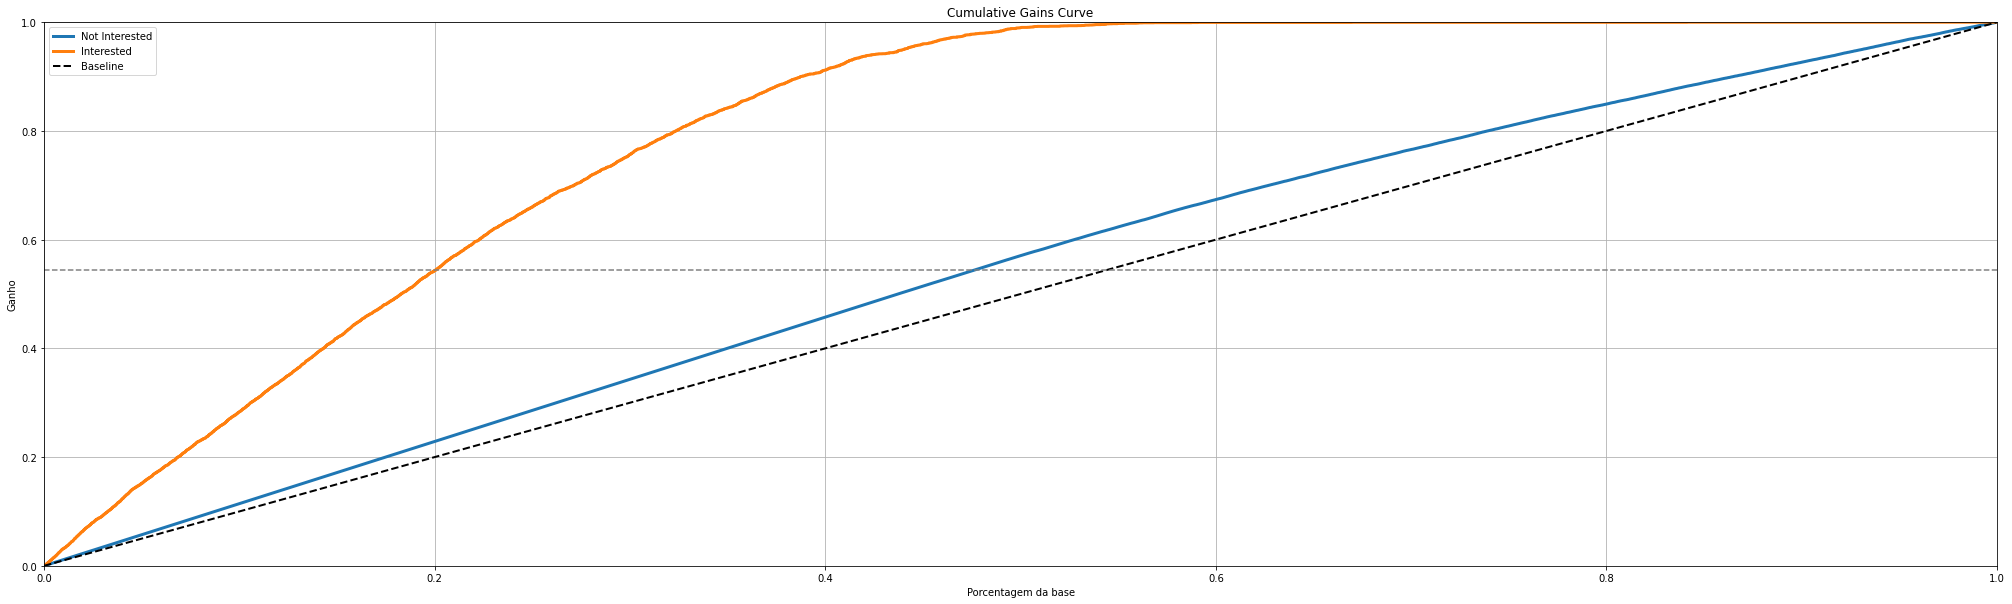

In [80]:
display( 'Acuracy: {:.3}% '.format( accuracy_score( y_te, y_pred ) * 100 ) )
skplt.metrics.plot_cumulative_gain( y_te, y_hat, figsize=(35,10) );
plt.legend(['Not Interested','Interested','Baseline']);
plt.xlabel( 'Porcentagem da base' );
plt.ylabel( 'Ganho' );
plt.axhline( y = .545, color ='gray', linestyle='--' );

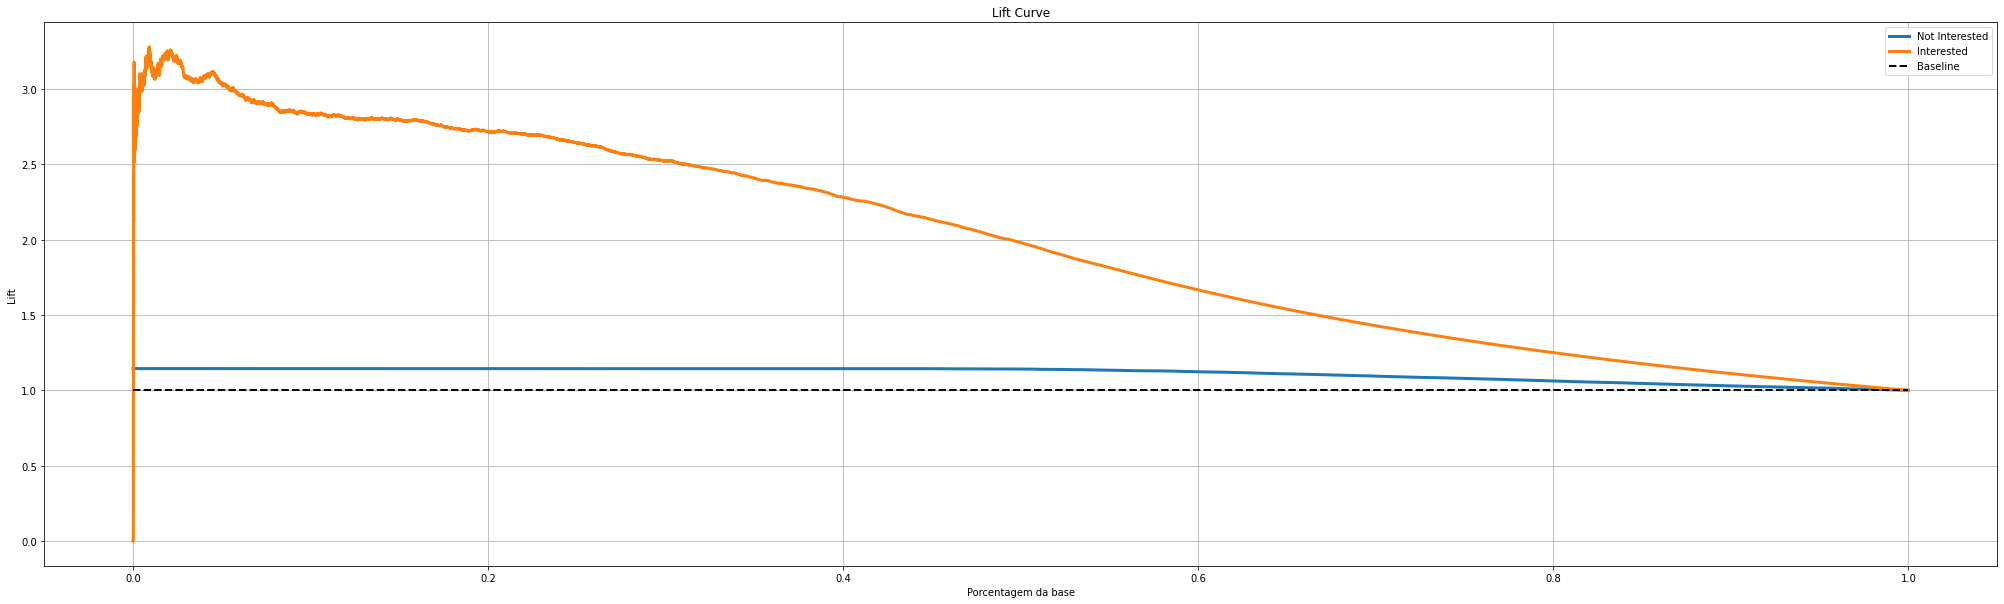

In [51]:
skplt.metrics.plot_lift_curve( y_te, y_hat, figsize=(35,10) )
plt.legend(['Not Interested','Interested','Baseline']);
plt.xlabel( 'Porcentagem da base' );
plt.ylabel( 'Lift' );

#### 12.2.2 Random Forest

In [87]:
rfc = pickle.load( open( '../data/Models/rand_forest.sav', 'rb' ) )
rfc.fit( x_tr, y_tr )

RandomForestClassifier(max_depth=4, min_samples_split=7, n_estimators=200)

In [88]:
y_hat = rfc.predict_log_proba( x_te )
y_pred = rfc.predict( x_te )

'Acuracy: 87.4% '

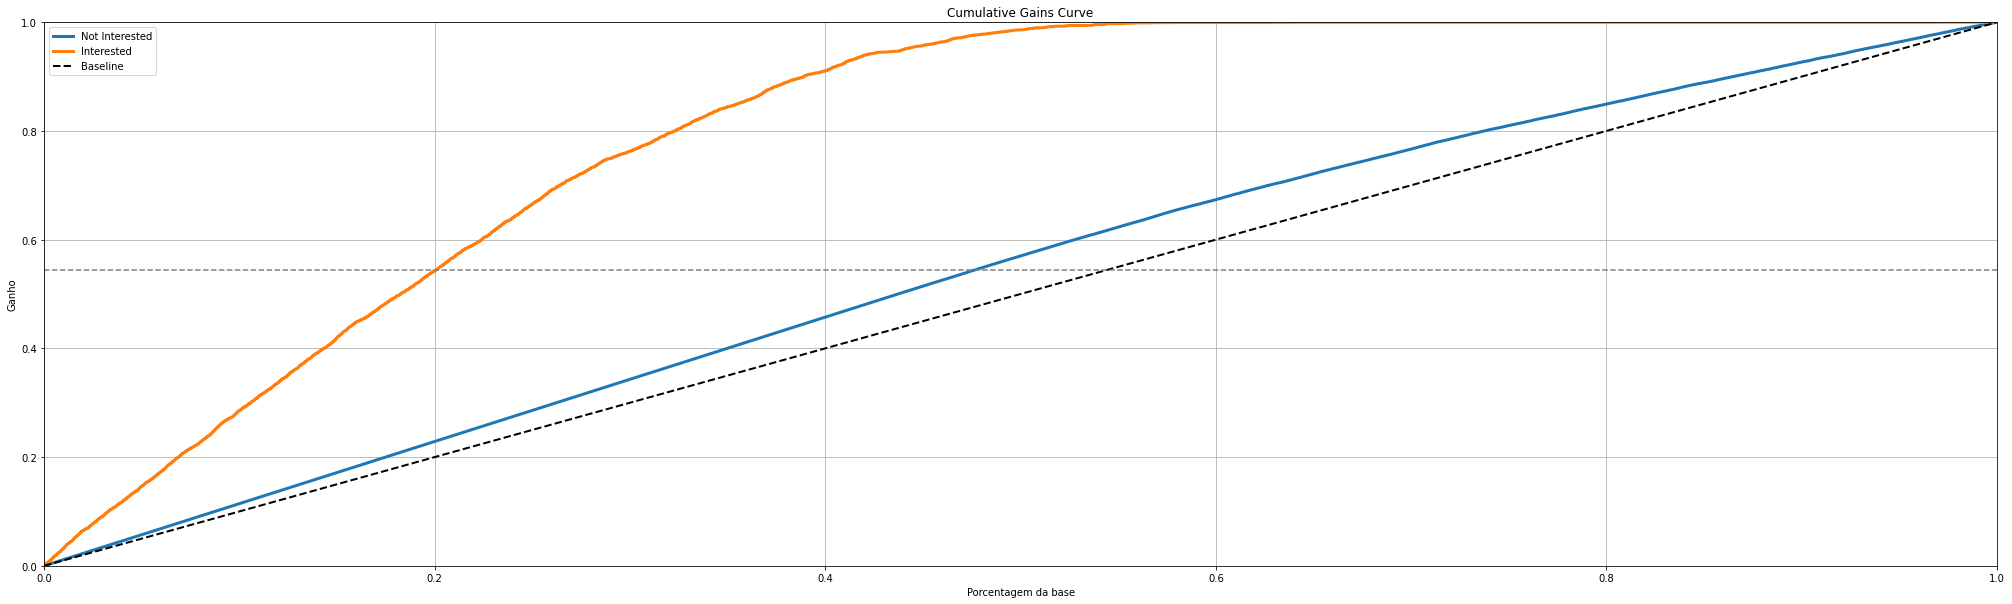

In [95]:
display( 'Acuracy: {:.3}% '.format( accuracy_score( y_te, y_pred ) * 100 ) )
skplt.metrics.plot_cumulative_gain( y_te, y_hat, figsize=(35,10) );
plt.legend(['Not Interested','Interested','Baseline']);
plt.xlabel( 'Porcentagem da base' );
plt.ylabel( 'Ganho' );
plt.axhline( y = .545, color ='gray', linestyle='--' );


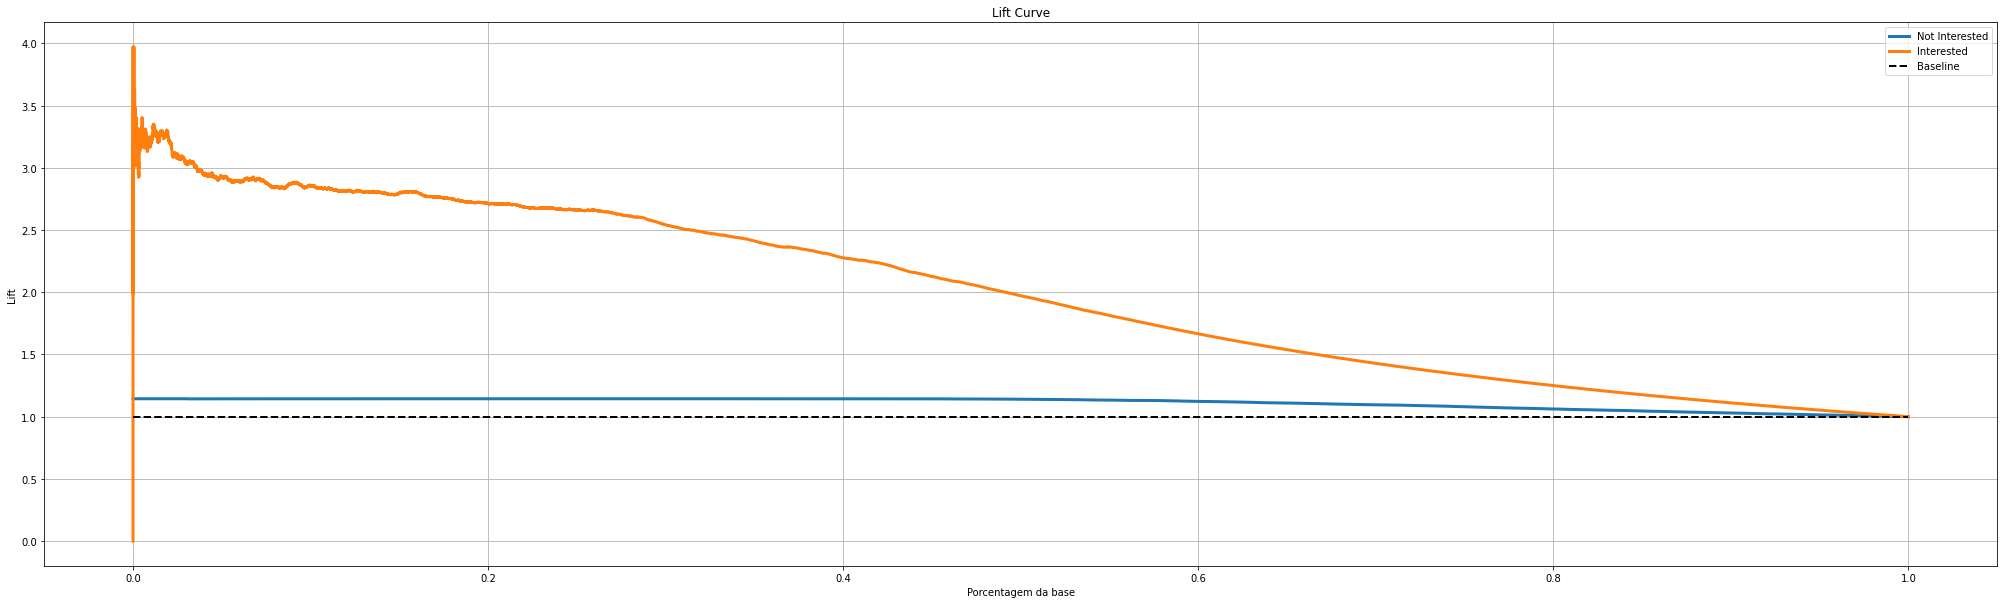

In [96]:
skplt.metrics.plot_lift_curve( y_te, y_hat, figsize=(35,10) );
plt.legend(['Not Interested','Interested','Baseline']);
plt.xlabel( 'Porcentagem da base' );
plt.ylabel( 'Lift' );

## 13. Rank

In [27]:
df_rank = x_te.copy()

In [32]:
df_rank['propensity_score']      = y_hat[0:, 1]
df_rank['target']       = y_te.values
df_rank                 = df_rank[['target','propensity_score']]
df_rank.sort_values( 'propensity_score', ascending=False, inplace=True )

df_rank.head( 4 )

,target,propensity_score
id,,
236772,1,0.4612
77317,1,0.4612
350790,1,0.4612
276876,0,0.4612


#### Precision/Recall @k

In [29]:
precision_at_50 = precision_at_k( df_rank, 50)
recall_at_50 = recall_at_k( df_rank, 50 )

print( 'Precision: {}, \nRecall: {} '.format(precision_at_50, recall_at_50) )

Precision: 0.54, 
Recall: 0.005627344726969571 
